# PRC2 Targets in CpG Islands

_Original paper: Moqri, Mahdi et al. "PRC2-AgeIndex as a universal biomarker of aging and rejuvenation." Nature communications vol. 15,1 5956. 16 Jul. 2024, [doi:10.1038/s41467-024-50098-2](https://www.nature.com/articles/s41467-024-50098-2)_.

The paper by Moqri et al looks at low-methylation regions (LMRs) that are enriched with PRC2 targets. The particular CpG islands that are bound by this transcriptional repressor seem to gain methylation with age at a very consistent rate and the authors suggest that it could be used as a universal biomarker of cellular aging. A really nice illustration of PRC2 binding is available in the graphical abstract of a different paper by Prorok et al, "Loss of Ezh2 function remodels the DNA replication initiation landscape", Cell Reports vol. 42, issue 4, 2023, [doi:10.1016/j.celrep.2023.112280](https://doi.org/10.1016/j.celrep.2023.112280):

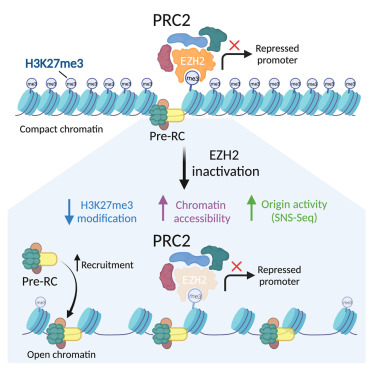

The uniprot entry for [EZH2](https://www.uniprot.org/uniprotkb/Q15910/entry#function) describes the mechanism very succintly:

> Catalytic subunit of the PRC2/EED-EZH2 complex, which methylates 'Lys-9' (H3K9me) and 'Lys-27' (H3K27me) of histone H3, leading to transcriptional repression of the affected target gene. Able to mono-, di- and trimethylate 'Lys-27' of histone H3 to form H3K27me1, H3K27me2 and H3K27me3, respectively. Displays a preference for substrates with less methylation, loses activity when progressively more methyl groups are incorporated into H3K27, H3K27me0 > H3K27me1 > H3K27me2 (PubMed:[22323599](https://www.uniprot.org/citations/22323599), PubMed:[30923826](https://www.uniprot.org/citations/30923826)).

In this project, we'll focus on only one of the samples of their ChIP-seq assay. It comes from epidermis cells from an 84-year-old donor and the antibody used for the pulldown was for EZH2. We won't go into the differential analysis, because the paper compares methylation of the LMRs, rather than differential expression. Instead, we'll investigate the binding sites of EZH2 across the human genome.

## Table of contents:

1. [Technical preparation](#Technical-preparation)
2. [Sequence download](#Sequence-download)
3. [Quality control](#Quality-control)
4. [Alignment](#Alignment)
5. [Coverage](#Coverage)
6. [Peak calling](#Peak-calling)
7. [Peak comparison](#Peak-comparison)
8. [Motif discovery](#Motif-discovery)
9. [Gene discovery](#Gene-discovery)
10. [Closing thoughts](#Closing-thoughts)

## Technical preparation

Before we download any samples, we'll prepare a directory structure of where we'll be storing intermediate and output files. To debug possible issues, we'll collect some logs and figures that we can include in the notebook.

We'll use a GRCh38 (hg38) genome assembly from NCBI: <https://www.ncbi.nlm.nih.gov/datasets/genome/GCF_000001405.40/>. This has been compiled into a bowtie2 reference that we've stored on the gbiomed server under `/mnt/storage/r0978323/`. A few other tools have been installed there and will be added to the PATH, to make sure we have newer versions that can handle the dataset. For instance, FastQC v0.11.5 raises warnings that it is parsing the FASTQ files incorrectly, but the one we're using, v0.12.1, doesn't have any issues with it.

In [1]:
mkdir -p data/fastq
mkdir -p data/bam
mkdir -p data/bw
mkdir -p data/peaks

mkdir -p fastqc
mkdir -p src
mkdir -p logs
mkdir -p figures

export HG38="/mnt/storage/r0978323/bowtie_hg38/hg38"
ls -lh $HG38*

export HG38_FASTA="/mnt/storage/r0978323/GCF_000001405.40_GRCh38.p14_genomic.fna"
head -2 "$HG38_FASTA"

export PATH="/mnt/storage/r0978323/micromamba/envs/project-2/bin:$PATH"
which cutadapt
which bamCoverage
which macs2

export PATH="/mnt/storage/r0978323/FastQC_v0.12.1:$PATH"
fastqc --version

export PATH="/mnt/storage/r0978323/TrimGalore_v0.6.10:$PATH"
trim_galore --version

export PATH="/mnt/storage/r0978323/bin:$PATH"
faCount

-rw-r--r-- 1 r0978323 domain users 1002M Dec 29 13:32 /mnt/storage/r0978323/bowtie_hg38/hg38.1.bt2
-rw-r--r-- 1 r0978323 domain users  748M Dec 29 13:35 /mnt/storage/r0978323/bowtie_hg38/hg38.2.bt2
-rw-r--r-- 1 r0978323 domain users   18K Dec 29 13:35 /mnt/storage/r0978323/bowtie_hg38/hg38.3.bt2
-rw-r--r-- 1 r0978323 domain users  748M Dec 29 13:27 /mnt/storage/r0978323/bowtie_hg38/hg38.4.bt2
-rw-r--r-- 1 r0978323 domain users 1002M Dec 29 13:42 /mnt/storage/r0978323/bowtie_hg38/hg38.rev.1.bt2
-rw-r--r-- 1 r0978323 domain users  748M Dec 29 13:38 /mnt/storage/r0978323/bowtie_hg38/hg38.rev.2.bt2
>NC_000001.11 Homo sapiens chromosome 1, GRCh38.p14 Primary Assembly
NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
/mnt/storage/r0978323/micromamba/envs/project-2/bin/cutadapt
/mnt/storage/r0978323/micromamba/envs/project-2/bin/bamCoverage
/mnt/storage/r0978323/micromamba/envs/project-2/bin/macs2
FastQC v0.12.1

                        Quality-/Adapter-/RRBS-/S

: 255

A copy of the full output from the notebook can be found under `/mnt/storage/r0978323/project_data/prc2_age_index/output`. Since many of the steps may take a long time to run, the fastqc output files or exploratory leiden images can be evaluated from that directory instead.

## Sequence download

We'll start by downloading the replicate sample and its input, performing quality control and aligning the two fastq files to hg38. The two files can be found on GEO:

| Sample                 | SRA id      | SRA run id  | URL                                                             |
| :-                     | :-          | :-          | :-                                                              |
| Old replicate 1        | SRX23335288 | SRR27667476 | <https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM8027713> |
| Old replicate 1, input | SRX23335283 | SRR27667481 | <https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSM8027708> |

The GEO accession also includes some of the processed files, like the called peaks: <https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE253773>. We'll later take those and compare them with our results to validate what we've done.

We'll start with the replicate fastq file to examine the results step by step. Then we'll prepare the input and move on to coverage and peak calling. The file's reads are paired, so we'll run `fastq-dump` with the recommended `--split-3` parameter to get reads in both directions. A third file doesn't seem to be created, so we can be confident that all the reads are correctly paired up.

In [2]:
export accession="SRR27667476"

echo "> Downloading fastq files..."
time fastq-dump -v --split-3 --outdir data/fastq/ "$accession"

echo "> Reads in downloaded fastq files:"
echo $(( $(wc -l "data/fastq/${accession}_1.fastq" | cut -d' ' -f1) / 4 ))
echo $(( $(wc -l "data/fastq/${accession}_2.fastq" | cut -d' ' -f1) / 4 ))

> Downloading fastq files...
Preference setting is: Prefer SRA Normalized Format files with full base quality scores if available.
SRR27667476 is an SRA Normalized Format file with full base quality scores.
Read 21073282 spots for SRR27667476
Written 21073282 spots for SRR27667476

real	14m22.931s
user	4m28.895s
sys	0m23.437s
> Reads in downloaded fastq files:
21073282
21073282


## Quality control

The number of reads in the file is 21,073,282 which matches the SRA information exactly. To see what we have, we'll run FastQC on this downloaded file and look for fixable issues.

In [3]:
# FastQC pre-trim
mkdir -p "fastqc/${accession}_1"
time fastqc "data/fastq/${accession}_1.fastq" -o "fastqc/${accession}_1"
mkdir -p "fastqc/${accession}_2"
time fastqc "data/fastq/${accession}_2.fastq" -o "fastqc/${accession}_2"

null
Started analysis of SRR27667476_1.fastq
Approx 5% complete for SRR27667476_1.fastq
Approx 10% complete for SRR27667476_1.fastq
Approx 15% complete for SRR27667476_1.fastq
Approx 20% complete for SRR27667476_1.fastq
Approx 25% complete for SRR27667476_1.fastq
Approx 30% complete for SRR27667476_1.fastq
Approx 35% complete for SRR27667476_1.fastq
Approx 40% complete for SRR27667476_1.fastq
Approx 45% complete for SRR27667476_1.fastq
Approx 50% complete for SRR27667476_1.fastq
Approx 55% complete for SRR27667476_1.fastq
Approx 60% complete for SRR27667476_1.fastq
Approx 65% complete for SRR27667476_1.fastq
Approx 70% complete for SRR27667476_1.fastq
Approx 75% complete for SRR27667476_1.fastq
Approx 80% complete for SRR27667476_1.fastq
Approx 85% complete for SRR27667476_1.fastq
Approx 90% complete for SRR27667476_1.fastq
Approx 95% complete for SRR27667476_1.fastq
Analysis complete for SRR27667476_1.fastq

real	2m15.447s
user	2m18.338s
sys	0m4.499s
null
Started analysis of SRR276674

Unfortunately, the raw set of reads includes adapters that we'll need to clean up: 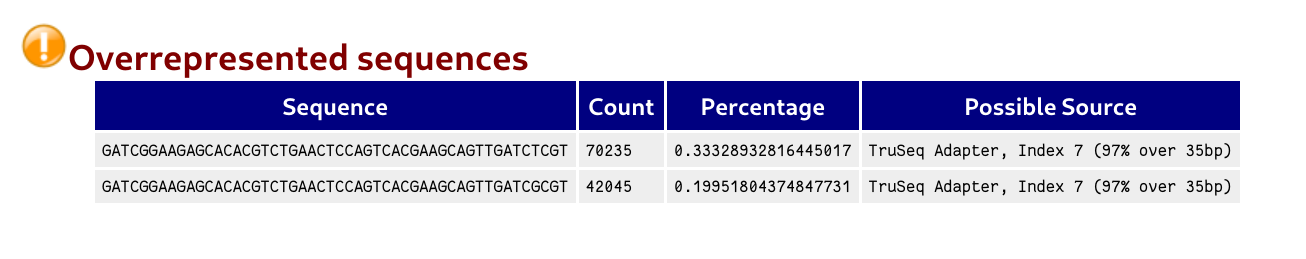

The paper uses [TrimGalore](https://github.com/FelixKrueger/TrimGalore) to automatically cut adapters from the sequence. It's a perl script that uses `cutadapt` underneath and performs other quality checks. It provides a way to run it with paired fastq sequences, so we'll provide both and then go back to examining the resulting files with FastQC:

In [4]:
set -e

# Use trim_galore to produce a pair of trimmed read files
cd data/fastq
trim_galore --paired "${accession}_1.fastq" "${accession}_2.fastq"
# Creates "${accession}_{1/2}_val_{1/2}.fq" inside the data/fastq directory
cd ../..

# We'll only keep the trimmed fastq files:
rm "data/fastq/${accession}_1.fastq"
rm "data/fastq/${accession}_2.fastq"

# Let's pick a clearer name and a consistent extension:
mv "data/fastq/${accession}_1_val_1.fq" "data/fastq/${accession}_trimmed_1.fastq"
mv "data/fastq/${accession}_2_val_2.fq" "data/fastq/${accession}_trimmed_2.fastq"

# FastQC post-trim:
mkdir -p "fastqc/${accession}_trimmed_1"
time fastqc "data/fastq/${accession}_trimmed_1.fastq" -o "fastqc/${accession}_trimmed_1"
mkdir -p "fastqc/${accession}_trimmed_2"
time fastqc "data/fastq/${accession}_trimmed_2.fastq" -o "fastqc/${accession}_trimmed_2"

Multicore support not enabled. Proceeding with single-core trimming.
Path to Cutadapt set as: 'cutadapt' (default)
Cutadapt seems to be working fine (tested command 'cutadapt --version')
Cutadapt version: 5.0
single-core operation.
Proceeding with 'gzip' for decompression
To decrease CPU usage of decompression, please install 'igzip' and run again

No quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)



AUTO-DETECTING ADAPTER TYPE
Attempting to auto-detect adapter type from the first 1 million sequences of the first file (>> SRR27667476_1.fastq <<)

Found perfect matches for the following adapter sequences:
Adapter type	Count	Sequence	Sequences analysed	Percentage
Illumina	4622	AGATCGGAAGAGC	1000000	0.46
Nextera	16	CTGTCTCTTATA	1000000	0.00
smallRNA	5	TGGAATTCTCGG	1000000	0.00
Using Illumina adapter for trimming (count: 4622). Second best hit was Nextera (count: 16)

Writing report to 'SRR27667476_1.fastq_trimming_report.txt'

SU

We are now left with 20,949,697 reads, some number of them being removed after adaptor cuts made them too short. There's a few potential issues that FastQC flags:

| Per-base sequence content | Per-sequence duplication percentage | Per-sequence GC content |
| :-: | :-: | :-: |
| 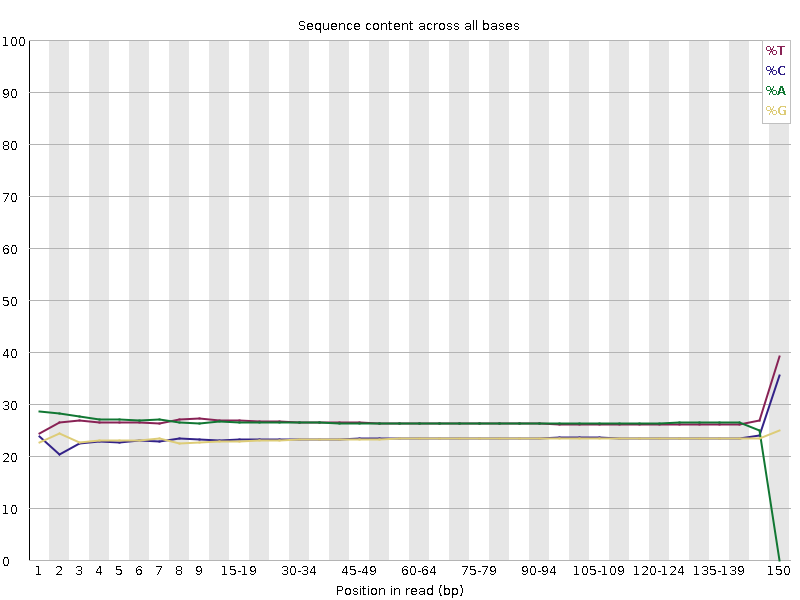 | 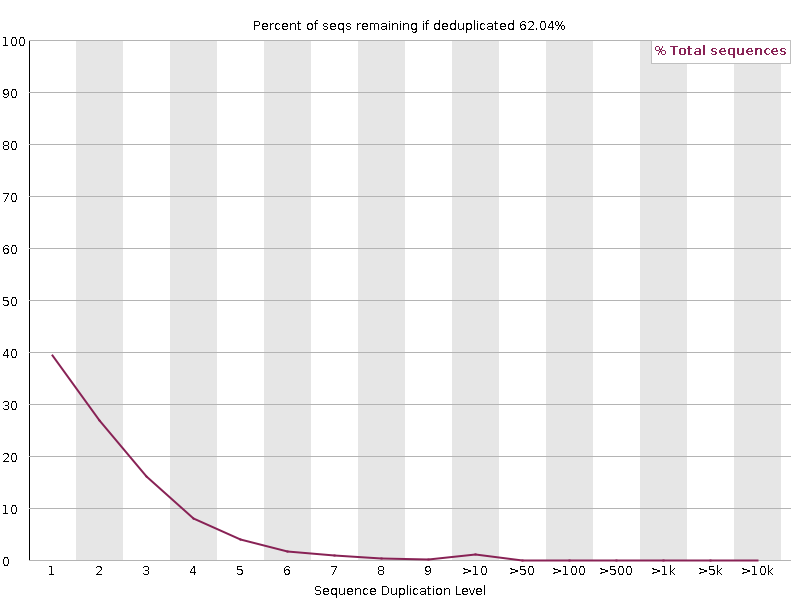 | 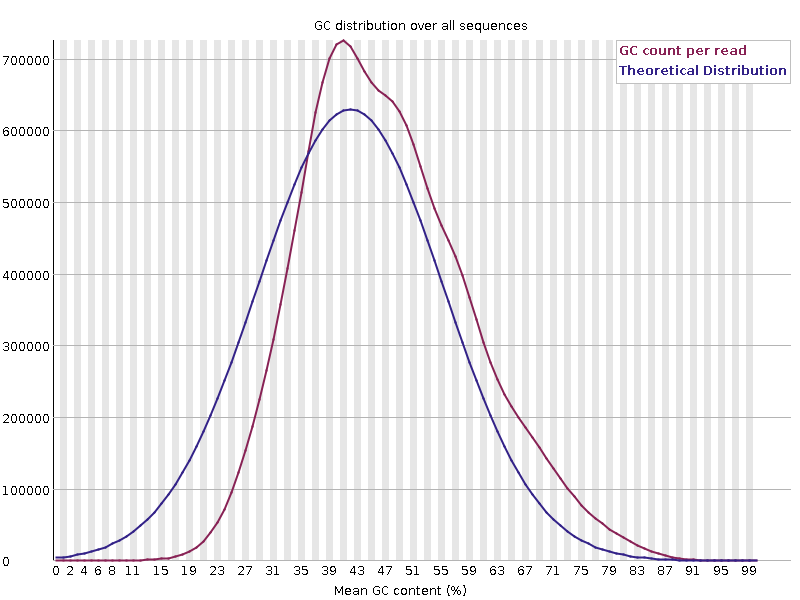 |

Since we are looking at a ChIP-seq experiment, we can expect that some motifs will be present at the edges of the reads, so it's natural that there is some variability at the beginning and end of the sequences. This also explains why there is some percentage of sequence duplication and possibly the GC content distribution. The PRC2 complex is known to bind close to CpG islands, so that might also be skewing the GC percentages.

## Alignment

Now that we have trimmed fastq files, we can align them to GRCh38. We'll provide both trimmed fastq files as pairs and produce a temporary SAM file with the aligned reads.

In [5]:
set -e

accession="SRR27667476"

# We can increase threads to speed up alignment, 
# but we'll use the default 1 to avoid high CPU usage
threads=1

# Align to hg38
echo "> Alignment: Working on ${accession}..."
time bowtie2 \
  -x "$HG38" \
  -p "$threads" \
  -1 "data/fastq/${accession}_trimmed_1.fastq" \
  -2 "data/fastq/${accession}_trimmed_2.fastq" \
  -S "data/bam/${accession}.sam" \
  | tee "logs/${accession}_bowtie.log"

> Alignment: Working on SRR27667476...
20949697 reads; of these:
  20949697 (100.00%) were paired; of these:
    1600333 (7.64%) aligned concordantly 0 times
    15746922 (75.17%) aligned concordantly exactly 1 time
    3602442 (17.20%) aligned concordantly >1 times
    ----
    1600333 pairs aligned concordantly 0 times; of these:
      29836 (1.86%) aligned discordantly 1 time
    ----
    1570497 pairs aligned 0 times concordantly or discordantly; of these:
      3140994 mates make up the pairs; of these:
        2889548 (91.99%) aligned 0 times
        143959 (4.58%) aligned exactly 1 time
        107487 (3.42%) aligned >1 times
93.10% overall alignment rate

real	233m3.746s
user	228m24.300s
sys	4m37.758s


Let's convert the SAM files to binary and take a look at the mapping using `samtools flagstat`:

In [6]:
# Convert to a binary file and remove the text one afterwards:
samtools view -S -b "data/bam/${accession}.sam" > "data/bam/${accession}.bam"
rm "data/bam/${accession}.sam"

# Calculate some statistics and save them in a log for later:
echo "> Flagstats for ${accession}.bam:"
samtools flagstat "data/bam/${accession}.bam" | tee "logs/${accession}_flagstats.log"

> Flagstats for SRR27667476.bam:
41899394 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
39009846 + 0 mapped (93.10% : N/A)
41899394 + 0 paired in sequencing
20949697 + 0 read1
20949697 + 0 read2
38698728 + 0 properly paired (92.36% : N/A)
38800354 + 0 with itself and mate mapped
209492 + 0 singletons (0.50% : N/A)
22584 + 0 with mate mapped to a different chr
8734 + 0 with mate mapped to a different chr (mapQ>=5)


There is an overall alignment rate of 93.10%, which is not bad. There is some discordant mapping and some unmapped reads. We'll remove them by filtering out the unmapped and secondary alignments and putting the filtered results in a "clean" file:

In [7]:
echo "> Clean unmapped/secondary reads for ${accession}.bam:"
samtools view -F 'UNMAP,SECONDARY' -O bam -o "data/bam/${accession}.clean.bam" "data/bam/${accession}.bam"

echo "> Flagstats for ${accession}.clean.bam:"
samtools flagstat "data/bam/${accession}.clean.bam" | tee "logs/${accession}_flagstats_clean.log"

> Clean unmapped/secondary reads for SRR27667476.bam:
> Flagstats for SRR27667476.clean.bam:
39009846 + 0 in total (QC-passed reads + QC-failed reads)
0 + 0 secondary
0 + 0 supplementary
0 + 0 duplicates
39009846 + 0 mapped (100.00% : N/A)
39009846 + 0 paired in sequencing
19520576 + 0 read1
19489270 + 0 read2
38698728 + 0 properly paired (99.20% : N/A)
38800354 + 0 with itself and mate mapped
209492 + 0 singletons (0.54% : N/A)
22584 + 0 with mate mapped to a different chr
8734 + 0 with mate mapped to a different chr (mapQ>=5)


We no longer have unmapped or discordant sequences in the resulting file. The number of reads is 39,009,846, which divided by two (for both reads in a pair) makes 19,504,923 reads for us to work with.

Let's now sort the BAM file and index it, so we can view it in the Integrated Genome Viewer (IGV).

In [8]:
echo "> Sort and index ${accession}.clean.bam:"
samtools sort -O bam -o "data/bam/${accession}.sorted.bam" "data/bam/${accession}.clean.bam"
samtools index "data/bam/${accession}.sorted.bam"

# Remove bam files other than the final sorted one
rm "data/bam/${accession}.bam"
rm "data/bam/${accession}.clean.bam"

> Sort and index SRR27667476.clean.bam:
[bam_sort_core] merging from 17 files and 1 in-memory blocks...


If we've reached this point, we should be able to remove the fastq files to save on space:

In [9]:
accession="SRR27667476"

rm "data/fastq/${accession}_trimmed_1.fastq"
rm "data/fastq/${accession}_trimmed_2.fastq"

Now we can do the same for the input sequences. We'll loop over both files, just in case we want to ignore the individual steps above and run this combined one. The script will check if a fastq file is already downloaded or processed before attempting to run the time-consuming steps on it.

We won't run the initial FastQC before trimming, but we'll perform a FastQC analysis after that and store it in the `fastqc/` directory.

In [10]:
accessions=(
  SRR27667476
  SRR27667481
)

# Note: the cell output (and its `time` output) is from threads=4
threads=1

for accession in "${accessions[@]}"; do
  # Download accession
  if [ -f "data/fastq/${accession}_trimmed_1.fastq" ] || [ -f "data/bam/${accession}.sorted.bam" ]; then
    echo "> Download: Skipping $accession, already downloaded or processed to a BAM file"
  else
    time fastq-dump -v --split-3 --outdir data/fastq/ "$accession"

    echo "> Reads in downloaded fastq files:"
    echo $(( $(wc -l "data/fastq/${accession}_1.fastq" | cut -d' ' -f1) / 4 ))
    echo $(( $(wc -l "data/fastq/${accession}_2.fastq" | cut -d' ' -f1) / 4 ))

    # Trim adaptors:
    cd data/fastq
    trim_galore --paired "${accession}_1.fastq" "${accession}_2.fastq"
    # Outputs "${accession}_trimmed.fq"
    cd ../..

    # Only keep the trimmed fastq files:
    rm "data/fastq/${accession}_1.fastq"
    rm "data/fastq/${accession}_2.fastq"
    mv "data/fastq/${accession}_1_val_1.fq" "data/fastq/${accession}_trimmed_1.fastq"
    mv "data/fastq/${accession}_2_val_2.fq" "data/fastq/${accession}_trimmed_2.fastq"

    # FastQC post-trim:
    mkdir -p "fastqc/${accession}_trimmed_1"
    time fastqc "data/fastq/${accession}_trimmed_1.fastq" -o "fastqc/${accession}_trimmed_1"
    mkdir -p "fastqc/${accession}_trimmed_2"
    time fastqc "data/fastq/${accession}_trimmed_2.fastq" -o "fastqc/${accession}_trimmed_2"
  fi

  # Align to hg38
  if [ -f "data/bam/${accession}.sorted.bam" ]; then
    echo "> Alignment: Skipping hg38 alignment for $accession, file exists"
  else
    echo "> Alignment: Working on ${accession}..."
    time bowtie2 \
      -x "$HG38" \
      -p "$threads" \
      -1 "data/fastq/${accession}_trimmed_1.fastq" \
      -2 "data/fastq/${accession}_trimmed_2.fastq" \
      -S "data/bam/${accession}.sam" \
      | tee "logs/${accession}_bowtie.log"

    # Convert to a binary file:
    samtools view -S -b "data/bam/${accession}.sam" > "data/bam/${accession}.bam"
    rm "data/bam/${accession}.sam"

    # Calculate statistics on generated file:
    echo "> Flagstats for ${accession}.bam:"
    samtools flagstat "data/bam/${accession}.bam" | tee "logs/${accession}_flagstats.log"

    echo "> Clean unmapped/secondary reads for ${accession}.bam:"
    samtools view -F 260 -O bam -o "data/bam/${accession}.clean.bam" "data/bam/${accession}.bam"
    
    # Calculate statistics on cleaned file:
    echo "> Flagstats for ${accession}.clean.bam:"
    samtools flagstat "data/bam/${accession}.clean.bam" | tee "logs/${accession}_flagstats_clean.log"

    echo "> Sort and index ${accession}.clean.bam:"
    samtools sort -O bam -o "data/bam/${accession}.sorted.bam" "data/bam/${accession}.clean.bam"
    samtools index "data/bam/${accession}.sorted.bam"

    # Remove bam files other than the final sorted one
    rm "data/bam/${accession}.bam"
    rm "data/bam/${accession}.clean.bam"
  fi

  # If we've reached this point, we should be able to clean up fastq files:
  if [ -f "data/fastq/${accession}_trimmed_1.fastq" ]; then
    rm "data/fastq/${accession}_trimmed_1.fastq"
  fi
  if [ -f "data/fastq/${accession}_trimmed_2.fastq" ]; then
    rm "data/fastq/${accession}_trimmed_2.fastq"
  fi
done

> Download: Skipping SRR27667476, already downloaded or processed to a BAM file
> Alignment: Skipping hg38 alignment for SRR27667476, file exists
Preference setting is: Prefer SRA Normalized Format files with full base quality scores if available.
SRR27667481 is an SRA Normalized Format file with full base quality scores.
Read 23622543 spots for SRR27667481
Written 23622543 spots for SRR27667481

real	14m32.085s
user	5m5.121s
sys	0m27.378s
> Reads in downloaded fastq files:
23622543
23622543
Multicore support not enabled. Proceeding with single-core trimming.
Path to Cutadapt set as: 'cutadapt' (default)
Cutadapt seems to be working fine (tested command 'cutadapt --version')
Cutadapt version: 5.0
single-core operation.
Proceeding with 'gzip' for decompression
To decrease CPU usage of decompression, please install 'igzip' and run again

No quality encoding type selected. Assuming that the data provided uses Sanger encoded Phred scores (default)



AUTO-DETECTING ADAPTER TYPE
Attempting 

The FastQC report of the input reads doesn't suggest any different issues than the replicate, so we'll move forwards with the next steps. The number of reads of the downloaded file is 23,622,543, which goes down to 23,102,060 after alignment (97.96% overall) and removal of unmapped reads.

## Coverage

To avoid having to load all reads into IGV, we'll produce a BigWig file with just the coverage. We'll use a small bin size of 5 to capture some level of detail. 

For the effective genome size, we took the advice of the [deeptools documentation](https://deeptools.readthedocs.io/en/stable/content/feature/effectiveGenomeSize.html) to run `faCount` on our genome fasta file:

> There are two common alternative ways to calculate this:
> 1. The number of non-N bases in the genome.
> 2. The number of regions (of some size) in the genome that are uniquely mappable (possibly given some maximal edit distance).
> Option 1 can be computed using faCount from [Kents tools](https://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/).

We downloaded the tool and ran it on our HG38 fasta file:

In [30]:
faCount -summary "$HG38_FASTA"

#seq	len	A	C	G	T	N	cpg
total	3298430636	923117203	642552917	645231996	925917038	161611482	32086716
prcnt	1.0  	0.2799	0.1948	0.1956	0.2807	0.0490	0.0097


The total sums of non-N bases is:
- A + C + G + T = 923117203 + 642552917 + 645231996 + 925917038 = **3136819154**, or
- Total - N = 3136819154 - 161611482 = **3136819154**

In [2]:
HG38_EFFECTIVE_SIZE="3136819154"
BIN_SIZE="5"

accessions=(
  SRR27667476
  SRR27667481
)

for accession in "${accessions[@]}"; do
  if [ -f "data/bw/${accession}.bw" ]; then
    echo "> Coverage: Skipping $accession, already processed to bw file"
  else
    time bamCoverage \
      -b "data/bam/${accession}.sorted.bam" \
      --normalizeUsing RPGC \
      --effectiveGenomeSize "$HG38_EFFECTIVE_SIZE" \
      -o "data/bw/${accession}.bw"  \
      -bs "$BIN_SIZE"
  fi
done

normalization: 1x (effective genome size 3136819154)
bamFilesList: ['data/bam/SRR27667476.sorted.bam']
binLength: 5
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None
bedFile: None
minMappingQuality: None
ignoreDuplicates: False
chrsToSkip: []
stepSize: 5
center_read: False
samFlag_include: None
samFlag_exclude: None
minFragmentLength: 0
maxFragmentLength: 0
zerosToNans: False
smoothLength: None
save_data: False
out_file_for_raw_data: None
maxPairedFragmentLength: 1000

real	38m54.654s
user	38m30.003s
sys	0m29.456s
normalization: 1x (effective genome size 3136819154)
bamFilesList: ['data/bam/SRR27667481.sorted.bam']
binLength: 5
numberOfSamples: None
blackListFileName: None
skipZeroOverZero: False
bed_and_bin: False
genomeChunkSize: None
defaultFragmentLength: read length
numberOfProcessors: 1
verbose: False
region: None
bedFile: None
minMappi

We can now take a look at our BigWig file and compare it with the peaks we can see ourselves on the read alignment. Some screenshots from IGV show reads stacking around the transcription start sites of several genes:

| HOXA13 ← | DAB2IP → | ELOVL2 ← |
| :-: | :-: | :-: |
| 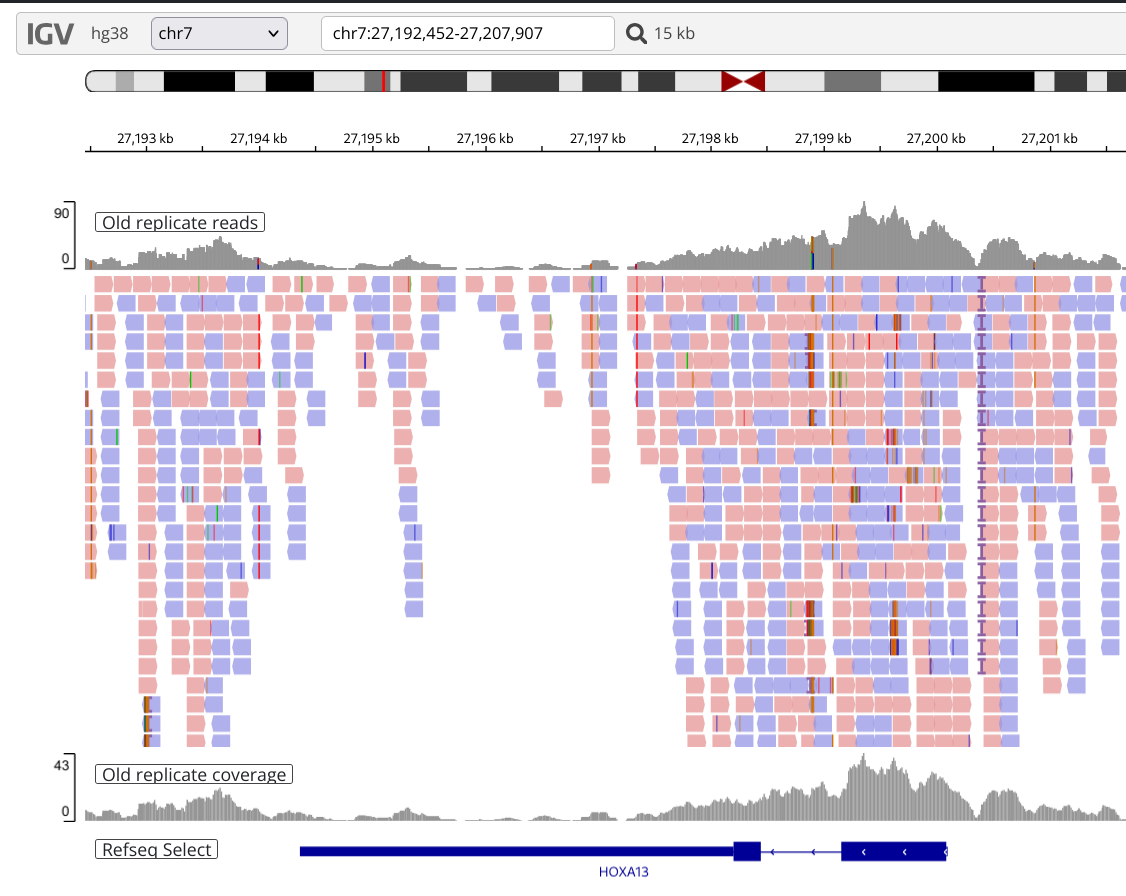 | 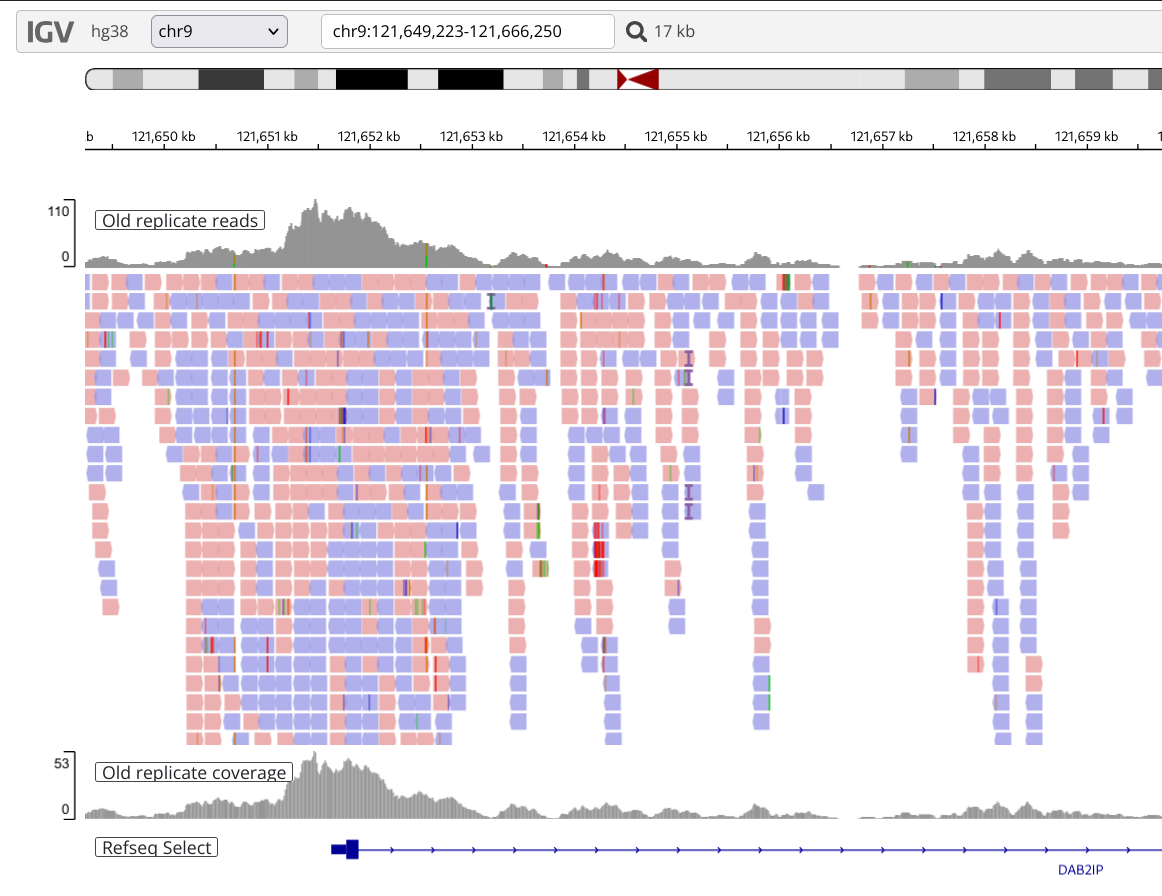 | 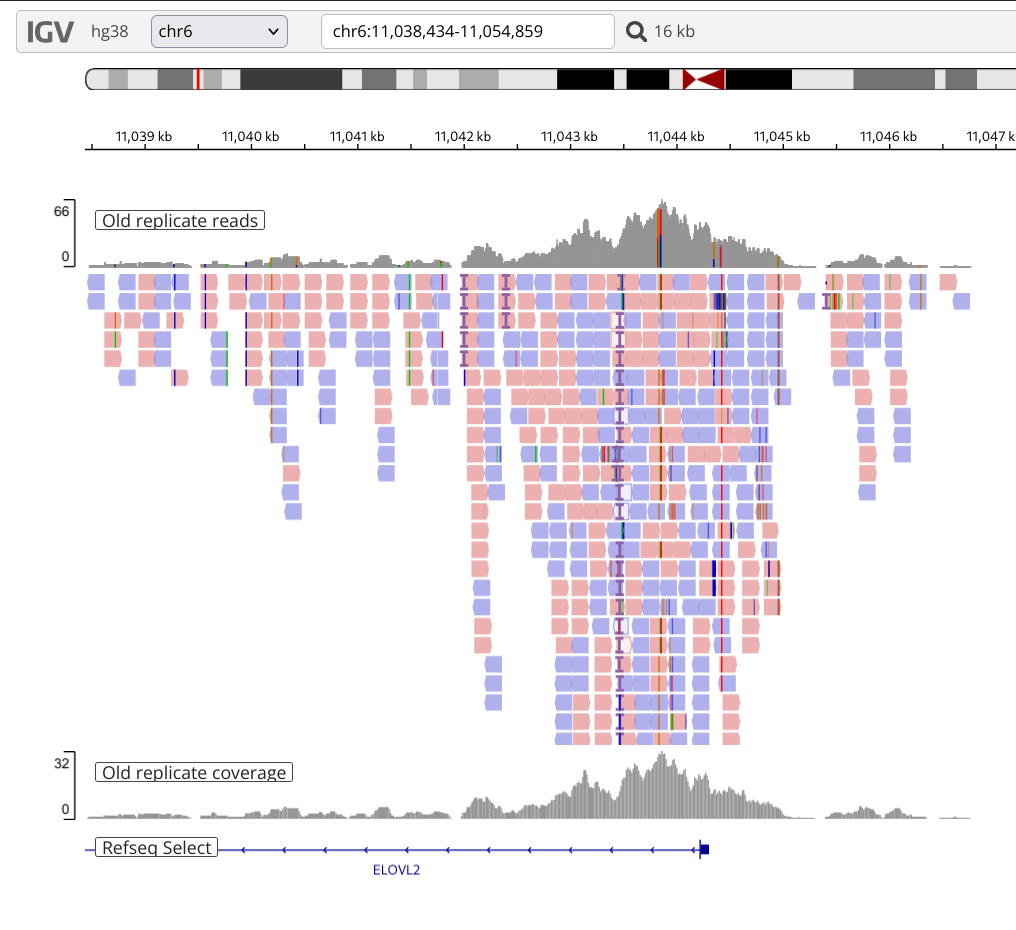 |

The ELOVL2 gene is mentioned in our main paper, while DAB2IP was picked as a target from [Min et al](https://doi.org/10.1038/nm.2100) and HOXA13 from [Buschbeck et al](https://doi.org/10.1038/nsmb.1665). A number of other homeobox genes are also suppressed by the PRC2 complex, as we'll see a bit later.

The BigWig peaks seem to align very nicely with the reads. Now we have to determine which of these are actually significant by comparing the replicate with the input control file.

## Peak calling

We'll use macs2 to call peaks based on the read counts with the input reads given as a control. We'll use the same effective genome size as we did for coverage generation and a q-value threshold of 0.05.

In [3]:
HG38_EFFECTIVE_SIZE="3136819154"

# Reference: https://www.ncbi.nlm.nih.gov/sra?term=SRX23335288
replicate="SRR27667476"

# Reference: https://www.ncbi.nlm.nih.gov/sra?term=SRX23335283
input="SRR27667481"

time macs2 callpeak \
  -t "data/bam/${replicate}.sorted.bam" \
  -c "data/bam/${input}.sorted.bam" \
  -n data/peaks/ezh2_old \
  -g "$HG38_EFFECTIVE_SIZE" \
  -q 0.05

INFO  @ Fri, 03 Jan 2025 16:08:38: 
# Command line: callpeak -t data/bam/SRR27667476.sorted.bam -c data/bam/SRR27667481.sorted.bam -n data/peaks/ezh2_old -g 3136819154 -q 0.05
# ARGUMENTS LIST:
# name = data/peaks/ezh2_old
# format = AUTO
# ChIP-seq file = ['data/bam/SRR27667476.sorted.bam']
# control file = ['data/bam/SRR27667481.sorted.bam']
# effective genome size = 3.14e+09
# band width = 300
# model fold = [5, 50]
# qvalue cutoff = 5.00e-02
# The maximum gap between significant sites is assigned as the read length/tag size.
# The minimum length of peaks is assigned as the predicted fragment length "d".
# Larger dataset will be scaled towards smaller dataset.
# Range for calculating regional lambda is: 1000 bps and 10000 bps
# Broad region calling is off
# Paired-End mode is off
 
INFO  @ Fri, 03 Jan 2025 16:08:38: #1 read tag files... 
INFO  @ Fri, 03 Jan 2025 16:08:38: #1 read treatment tags... 
INFO  @ Fri, 03 Jan 2025 16:08:38: Detected format is: BAM 
INFO  @ Fri, 03 Jan 2025 

We'll execute the given R script that describes the macs2 peak-calling model and examine the images in a later cell below:

In [4]:
Rscript data/peaks/ezh2_old_model.r

null device 
          1 


As we can see below, the number of peaks we find is 12,344. It's a fairly large amount, but we're looking at a complex that acts quite broadly on the genome, so it's to be expected. We can see from the initial illustration that it doesn't bind directly to DNA sequences but to histones, with preference for low-methylated CpG islands.

In [5]:
wc -l data/peaks/ezh2_old_peaks.narrowPeak

12344 data/peaks/ezh2_old_peaks.narrowPeak


We'll create a bed file that we'll use for functional analysis and finish this section by generating a heatmap that visualizes the distribution of normalized reads around the peaks. First, we need to compute a matrix of normalized counts which will take about 15 minutes. In the next cell, we'll generate the actual heatmap.

In [6]:
cat data/peaks/ezh2_old_peaks.narrowPeak | cut -f 1-3 > data/peaks/ezh2_old_peaks.bed

time computeMatrix reference-point \
    --scoreFileName data/bw/SRR27667476.bw \
    --regionsFileName data/peaks/ezh2_old_peaks.bed \
    --referencePoint center \
    --upstream 3000 \
    --downstream 3000 \
    --binSize 5 \
    --outFileName data/peaks/ezh2_old_peaks.tab.gz


real	13m30.463s
user	13m32.118s
sys	0m5.064s


In [13]:
plotHeatmap \
    --matrixFile data/peaks/ezh2_old_peaks.tab.gz \
    --outFileName figures/ezh2_old_peaks.png \
    --heatmapHeight 15 \
    --heatmapWidth 6 \
    --refPointLabel "peak center" \
    --regionsLabel peaks

| Heatmap | Peak model | Cross-correlation |
| :-: | :-: | :-: |
| 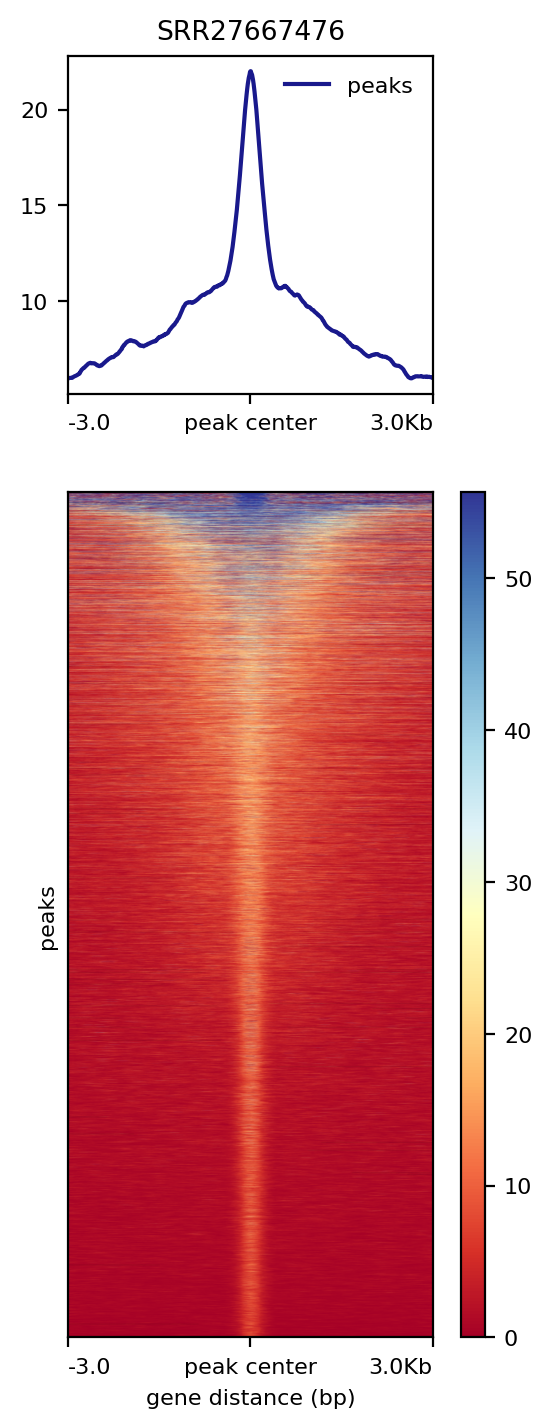 | 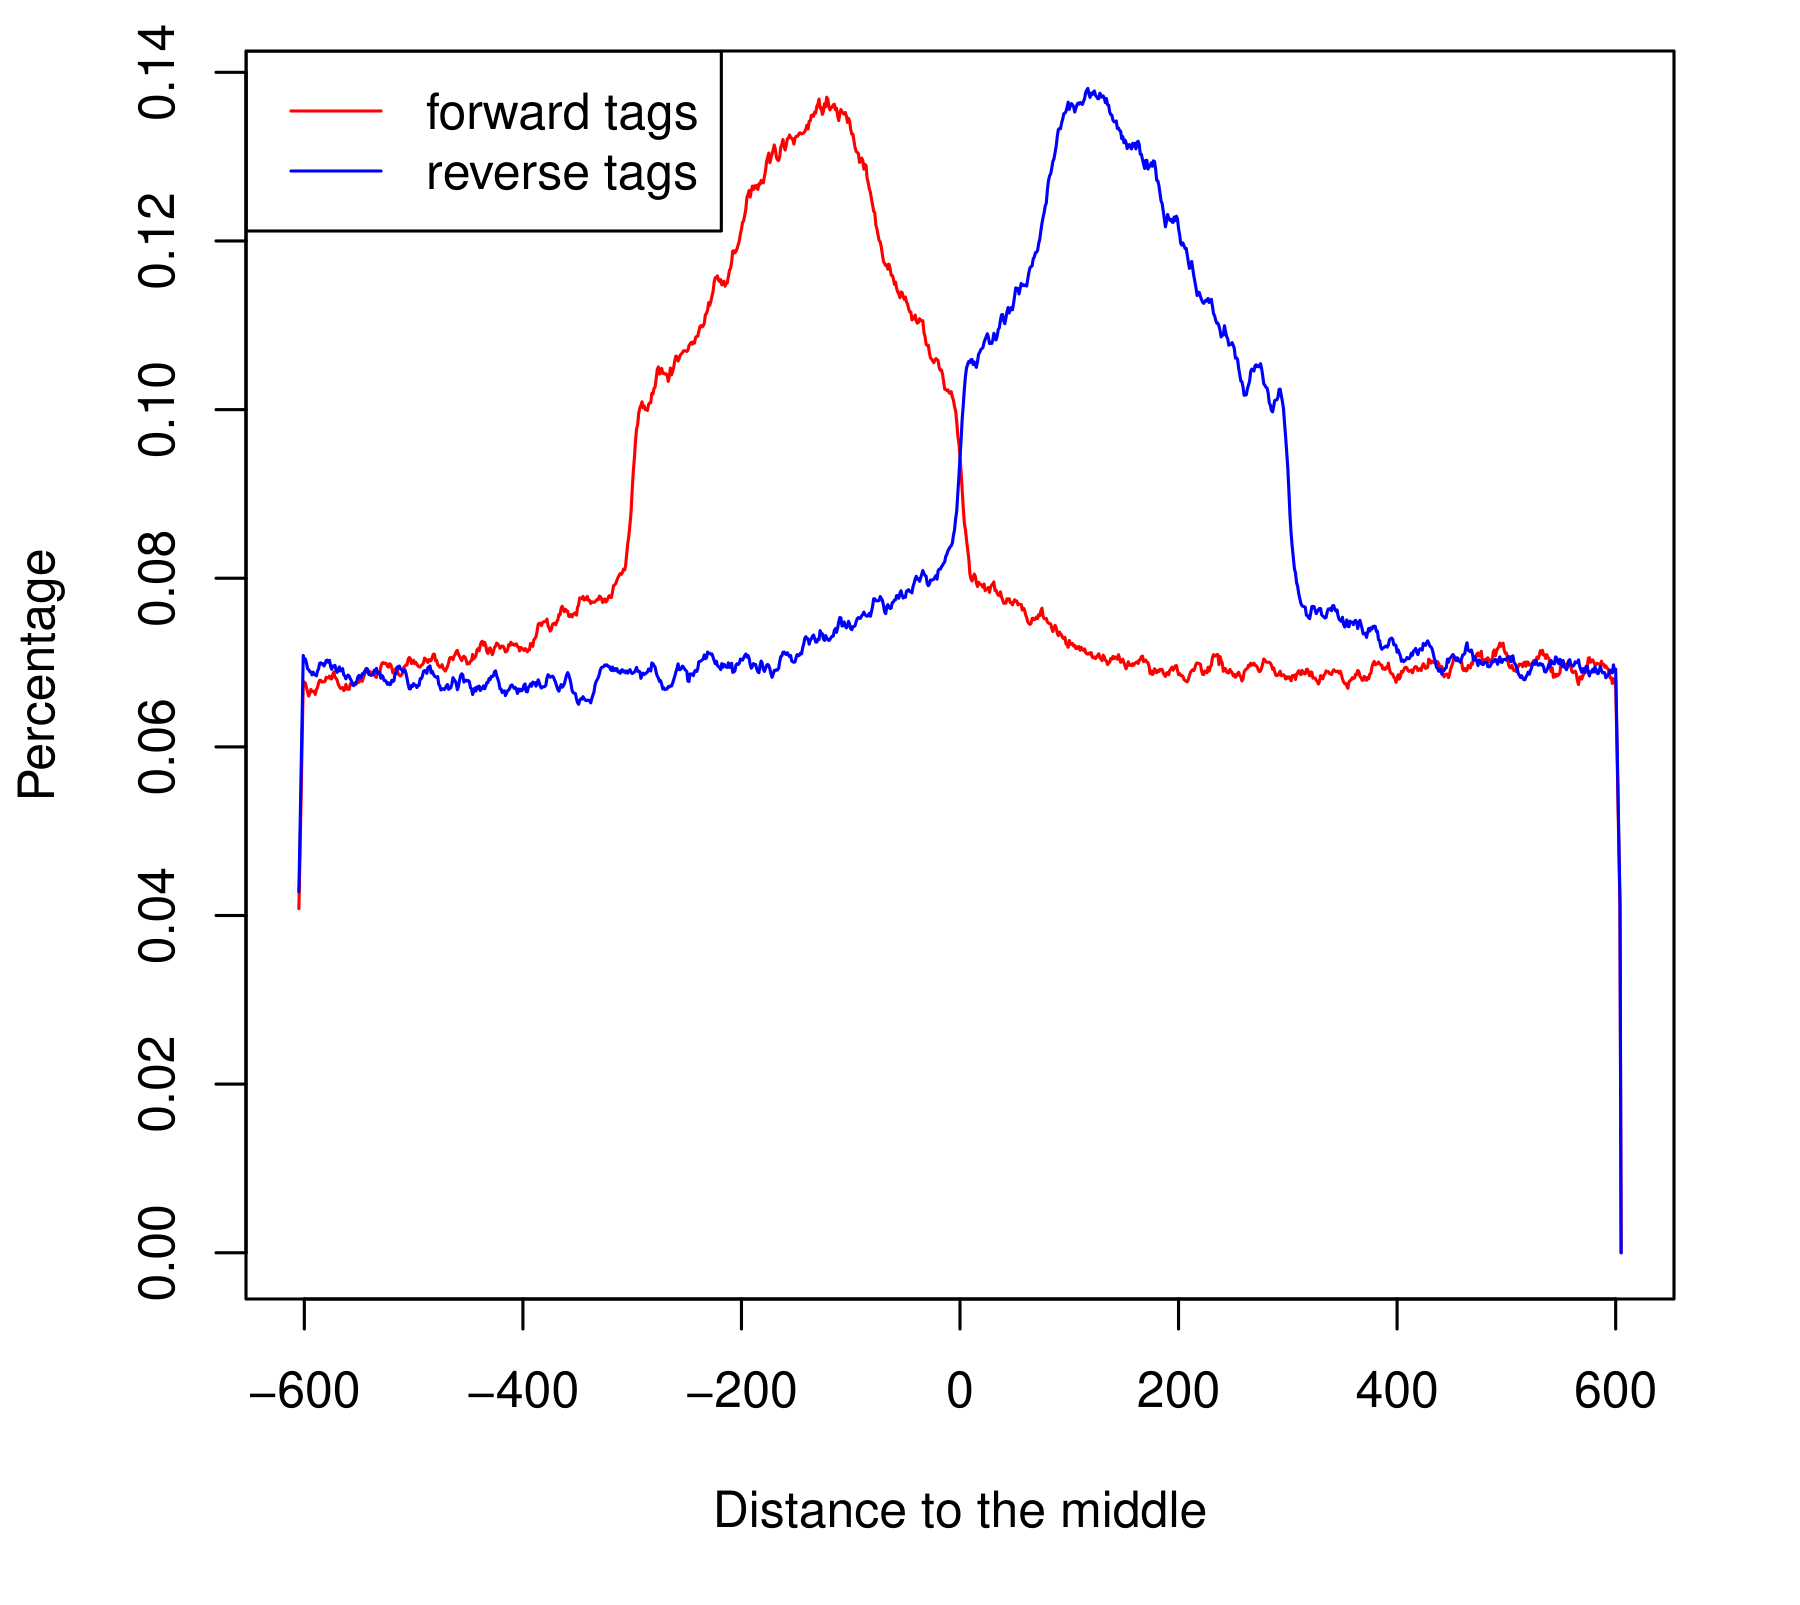 | 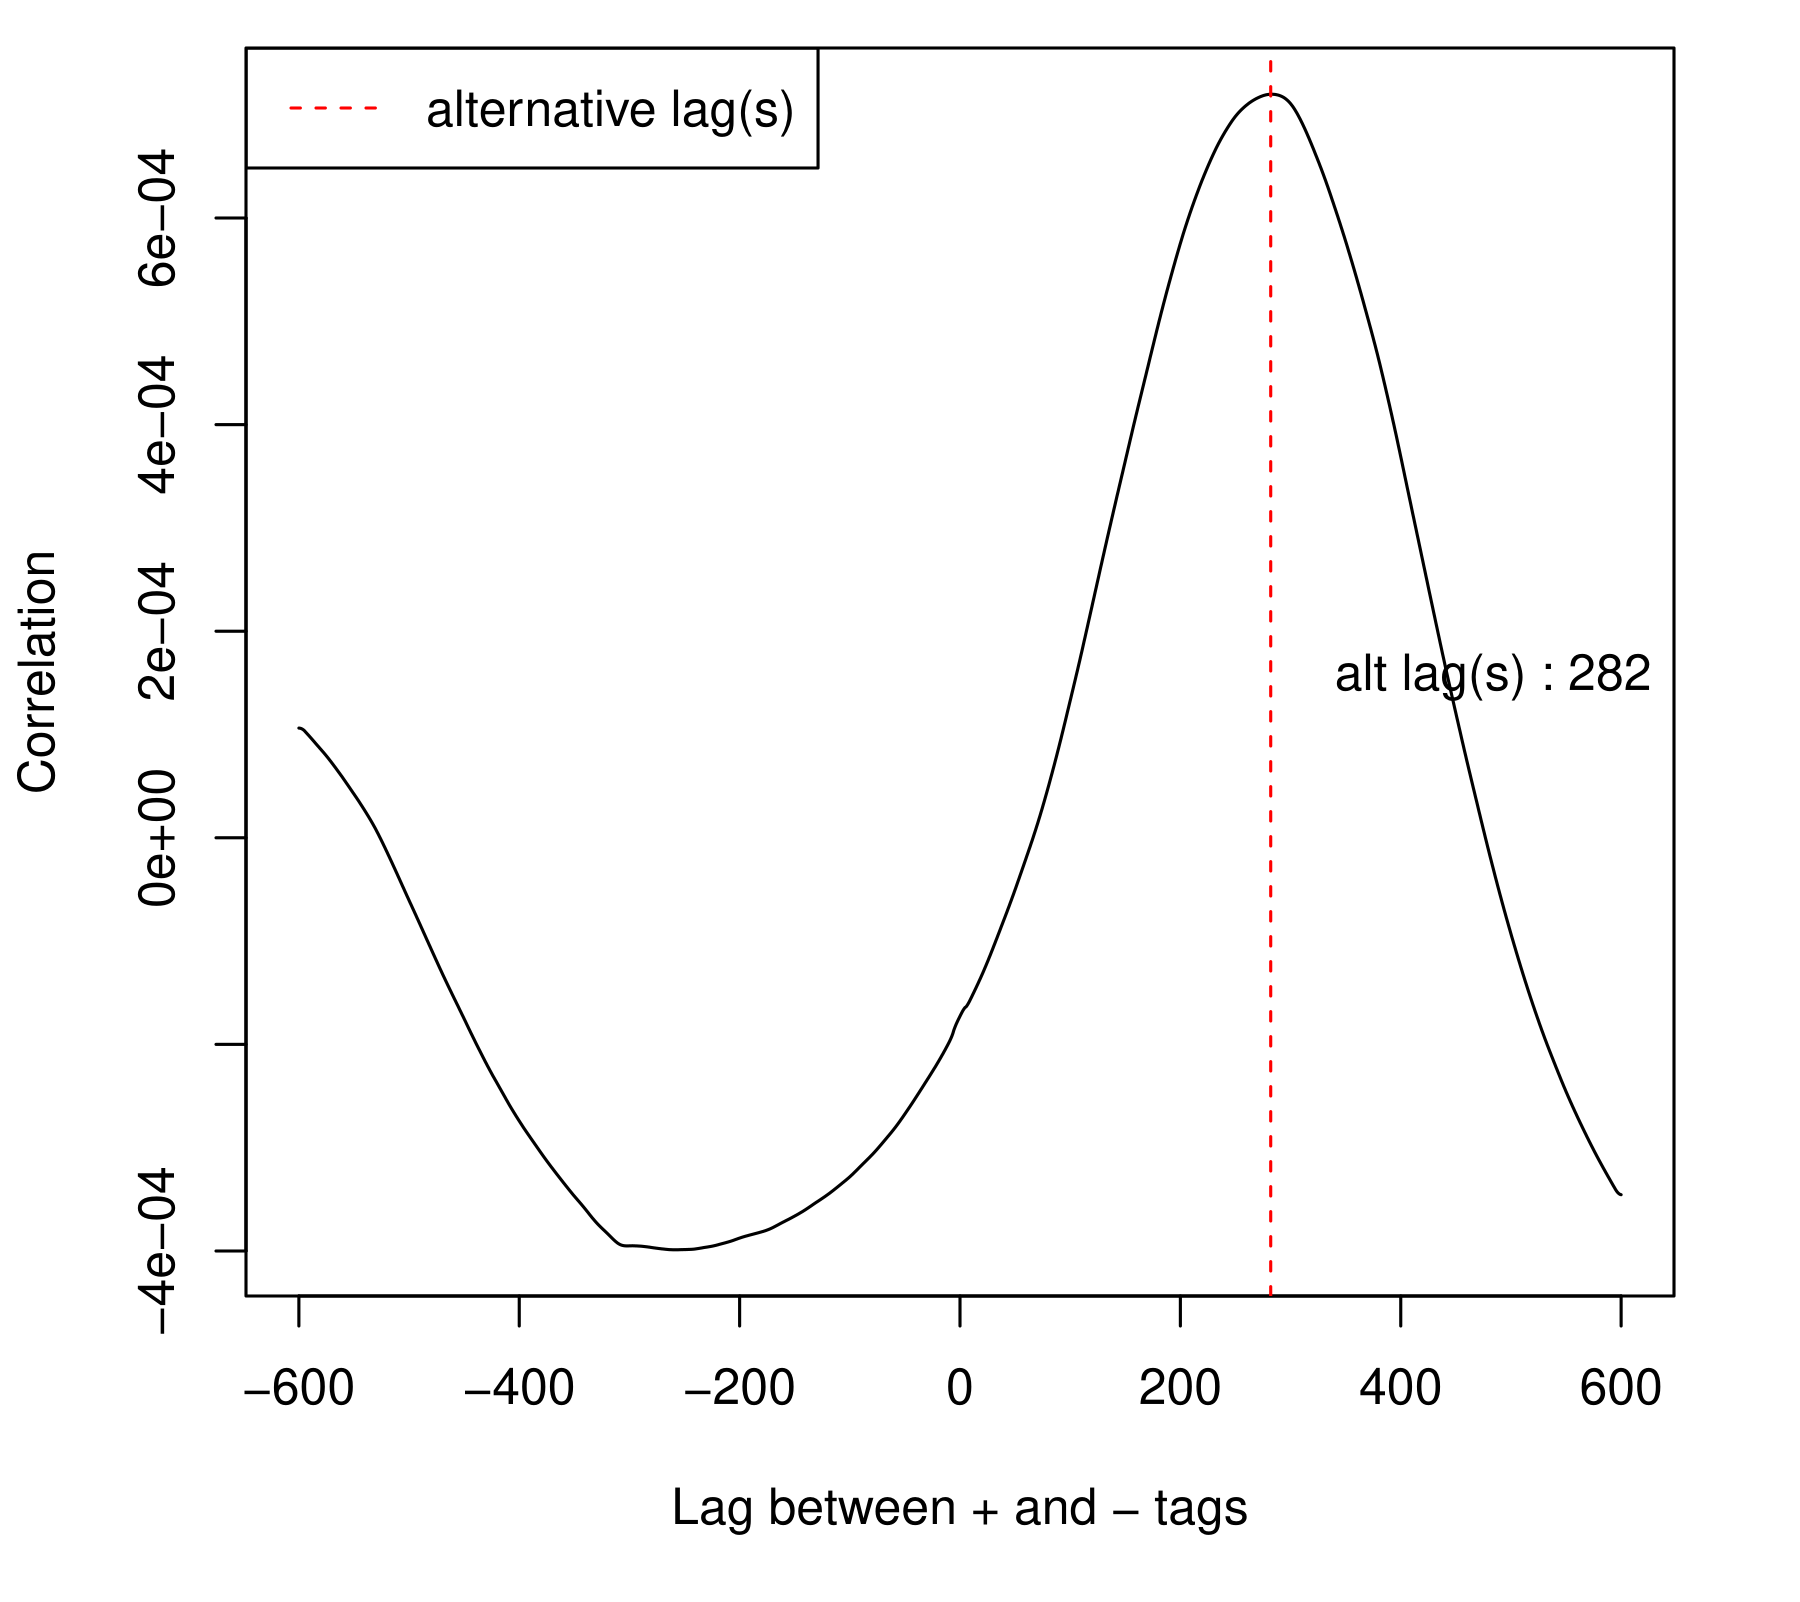 |

The heatmap for EZH2 peaks across the genome is on the left. We can see a very sharp peak in the middle, but a fairly wide tail of other binding around it in a 3kbp radius. It's an interesting shape, because it's somewhat inbetween a narrow and a broad binding pattern. If we explore some of the bindings in IGV, we can sometimes see peaks called both at the starts of genes, and shorter ones in their bodies:

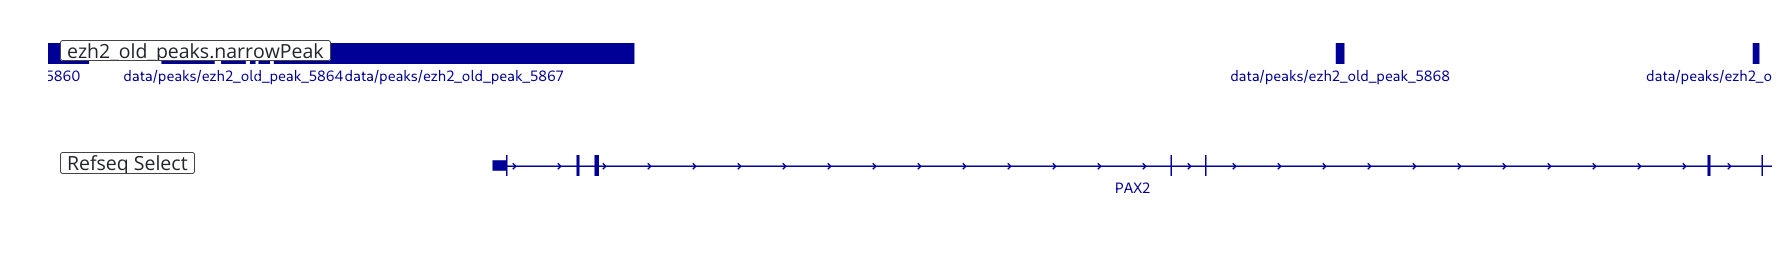

The model for forward and reverse reads shows them being distributed around 150bp before and after the binding site, confirmed by the cross-correlation measurement pinning the lag between them at 282bp. The model suggests a bimodal distribution of reads, as described by Wilbanks et al in "Evaluation of Algorithm Performance in ChIP-Seq Peak Detection", [doi:10.1371/journal.pone.0011471](https://doi.org/10.1371/journal.pone.0011471). Even though the complex binds to histones, it seems to bind areas with some specificity and act more like a DNA-binding factor.

## Peak comparison

Now that we have a narrow peaks file, we would like to see how it compares to the processed file uploaded by the authors of the study. The [GEO accession](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE253773) includes their narrow peak files as well, which we've placed in `/mnt/storage/r0978323/project_data/prc2_age_index/downloaded`. We'll symlink the files here and upload them to IGV to compare.

In [8]:
if [ ! -f data/peaks/ezh2_old_downloaded.narrowPeak ]; then
  ln -s \
      /mnt/storage/r0978323/project_data/prc2_age_index/downloaded/GSE253773_O1P2_peaks.narrowPeak \
      ./data/peaks/ezh2_old_downloaded.narrowPeak
fi

if [ ! -f data/peaks/ezh2_neonatal_downloaded.narrowPeak ]; then
  ln -s \
      /mnt/storage/r0978323/project_data/prc2_age_index/downloaded/GSE253773_N1P2_peaks.narrowPeak \
      ./data/peaks/ezh2_neonatal_downloaded.narrowPeak
fi

ls data/peaks/*.narrowPeak

data/peaks/ezh2_neonatal_downloaded.narrowPeak
data/peaks/ezh2_old_downloaded.narrowPeak
data/peaks/ezh2_old_peaks.narrowPeak


We can start by comparing the number of peaks detected between the files:

In [9]:
wc -l data/peaks/*.narrowPeak

  61493 data/peaks/ezh2_neonatal_downloaded.narrowPeak
  25139 data/peaks/ezh2_old_downloaded.narrowPeak
  12344 data/peaks/ezh2_old_peaks.narrowPeak
  98976 total


The old peak replicate that we downloaded has more than twice the peaks we detected! The neonatal sample has more than twice that amount, too.

The fact that the neonatal ChIP-seq would produce more binding sites is to be expected. This complex binds low-methylated regions that increase in methylation with age. It's natural that it would bind to fewer and fewer places over time.

It's harder to judge why our old sample is different from theirs. Let's try a visual inspection of a particular binding site, DAB2IP:

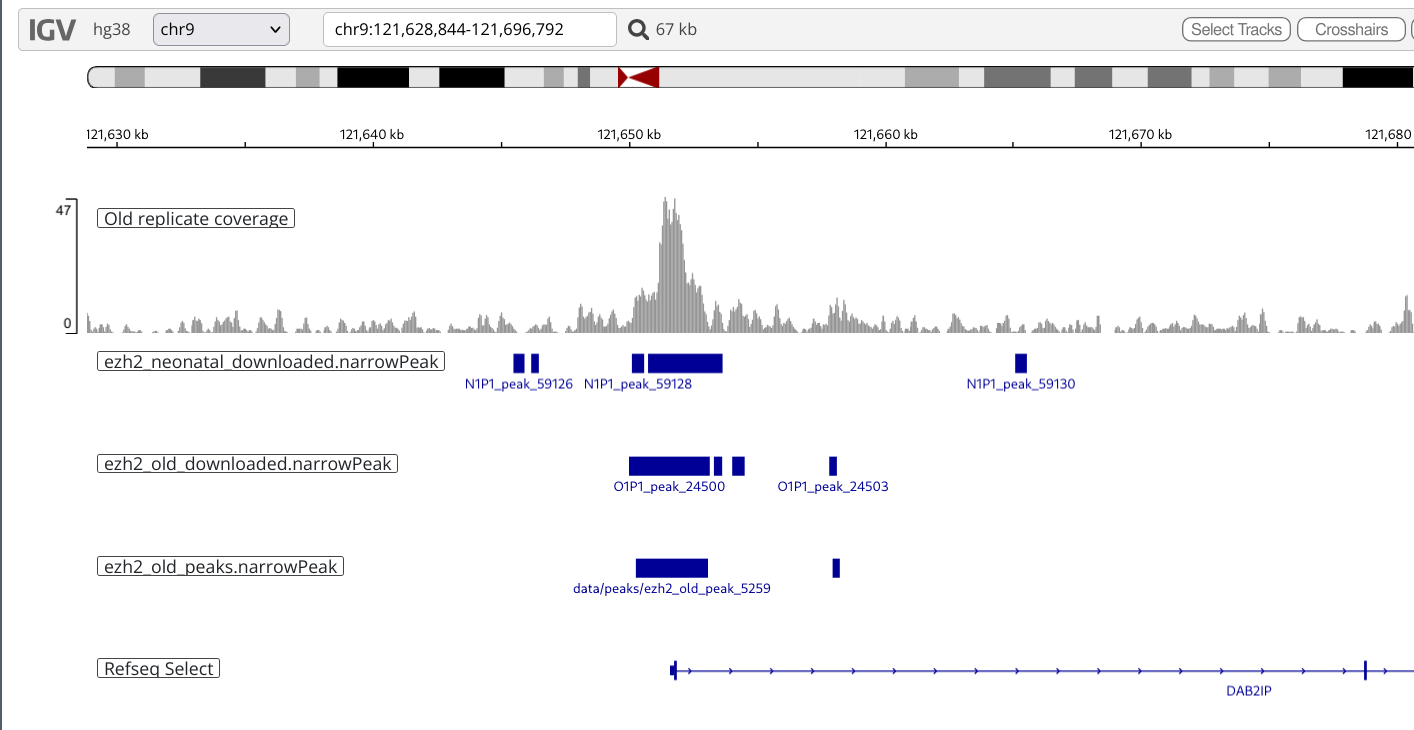

At the top, we can see the BigWig coverage that we generated, then from top to bottom, we have the downloaded neonatal peaks, the downloaded old peaks, and our own peaks. The neonatal peaks agree in the central area, but add more binding sites in the UTR and first intron of the gene. If we zoom out and render a track with the reads stored in the bam file...

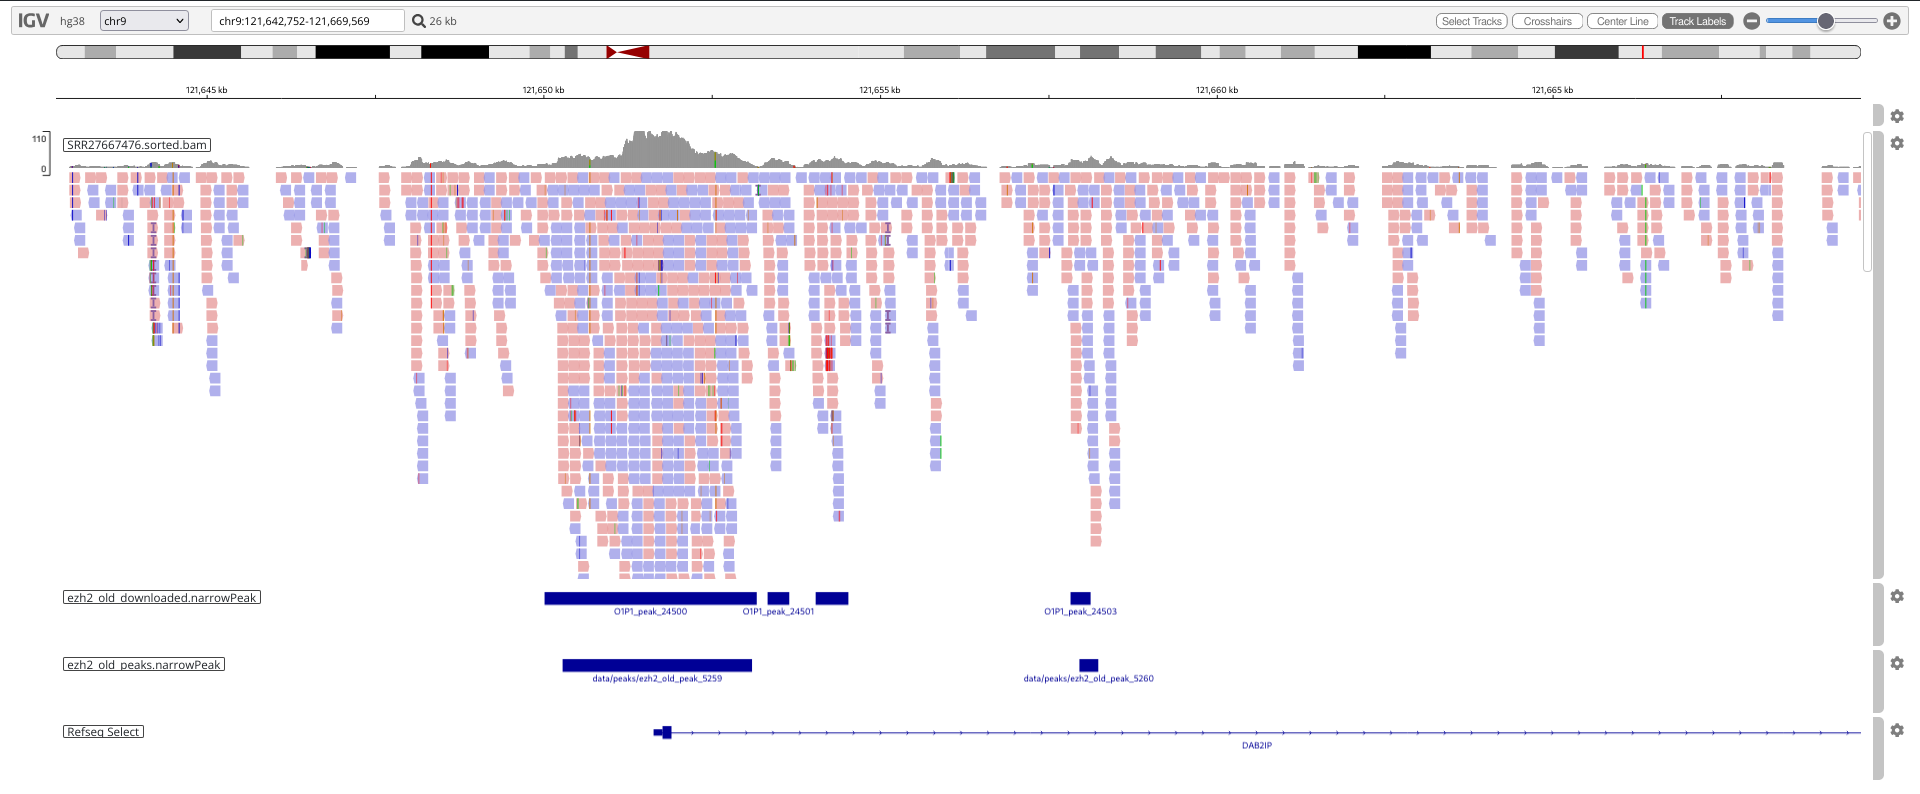

There's certainly some visible peaks in the downloaded sample that our tool did not consider to be significant. An attempt was made to loosen the q-value threshold from 0.05 to 0.10, but that only resulted in about 200 more peaks. The paper does not specify a q-value threshold, but the default is 0.05, so it's hard to say if that's the reason for the discrepancy. They used a slightly older version of MACS2, but it seems unlikely that their algorithm would change differential calling like that. Here's what they have to say about peak calling in their "Methods" section:

> The following processing steps were conducted as per the ENCODE3 ChIP-Seq Pipeline. [...] MACS2 (version 2.2.7.1) callpeak was run on each individual tissue with replicates merged for each tissue/passage, and a fold enrichment signal track was built using the bdgcmp (narrowpeak files were also called for each replicate separately for differential binding analysis, see next section). 

The "next section" goes into differential analysis, but does not elaborate on the specifics of their calling method. The `bdgcmp` command should deduct noise, so it seems more likely to *remove* peaks than to call extra ones. One thing that might be causing the discrepancy is that we mapped the reads to a genome that includes scaffolds that are not mapped to chromosomes, which may have diverted some reads that would have been stacked in our missing regions. 

Still, the peaks we see in IGV are close to the ones we call, so we would expect that the differences should not change the gene list we end up too much. Let's start by inspecting enriched motifs in RSAT and then find a list of genes close to the binding sites through GREAT.

## Motif discovery

We'll start by extracting FASTA sequences for the bed file we created earlier. We'll use the same genome we used for mapping:

In [17]:
bedtools getfasta \
  -fi "$HG38_FASTA" \
  -bed data/peaks/ezh2_old_peaks.bed \
  -fo data/peaks/ezh2_old_peaks.fasta

head -5 data/peaks/ezh2_old_peaks.fasta

>NC_000001.11:48306-48588
AGAATTAAAGGGGTAATTATCAGAATGAAAATGGTTTAATGAAACTGTGTCTATCAGTTCTGAAAAGGGCCTCTATCACAATGAACTAAGGTAGTTATGAATAGAGCTAAAACTTAGGCAacaccatcctggacataggaacgggcaaagatttcatgacaaagacacggaaaccaatcacaacaaaagcaaaaattgagaagTGGAATCTAATAAAacaatagcttctgcacagcaaaagaagctaccaacaaagtaaacagacaacctacagaatgggag
>NC_000001.11:48797-49159
gagatatcatctcataccaggcagaatggctattattaaaaagtcaaaaataacagatatcggtgaggttacagagaaaagggaacacttatacactgttggtgggactgtaaattatttcaaccattgtggaaagcagtatgggatggcgattcctcaaaaagccaaaaacagaactatcattcaacccagcaattccattactgggtatatacccagaagaatataaatcgttctaccataaagacgcatgcatgagaatgttcattgcagcactactcacaatagcagagacatggaatcaacttaaatgcccatcagtaacagactggataaagaaagtgtggtacagatacaccgtg
>NC_000001.11:108980-109667


RSAT returns a lot of interesting information about the kinds of motifs that the PRC2 complex associates with. We can start with sequence composition: 

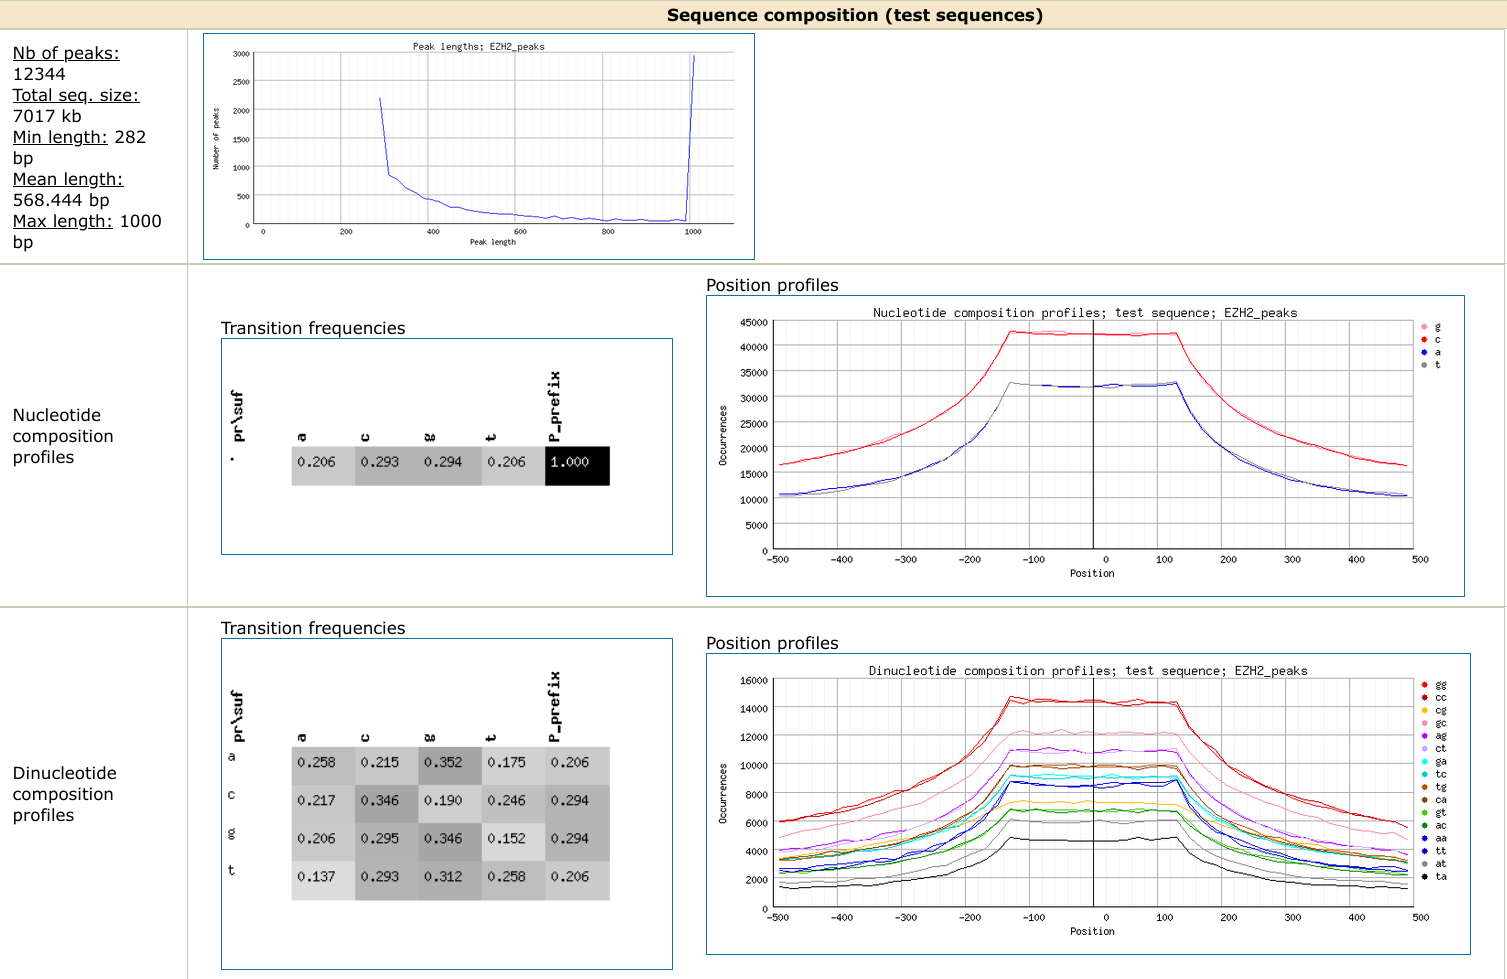

Peak lengths seem to separate into two clusters, one with ~280bp and one with 1000bp peaks. It's a bit odd to see one peak of length an entire kilobasepair, but we can imagine that some regions of heterochromatin might be densely bound with PRC2. In order to limit the results to the subset of short, more targeted bindings, we tried RSAT's "Reduce peak sequences" option to cut peaks to +/-150bp around the center, but it didn't produce notable changes in the results:

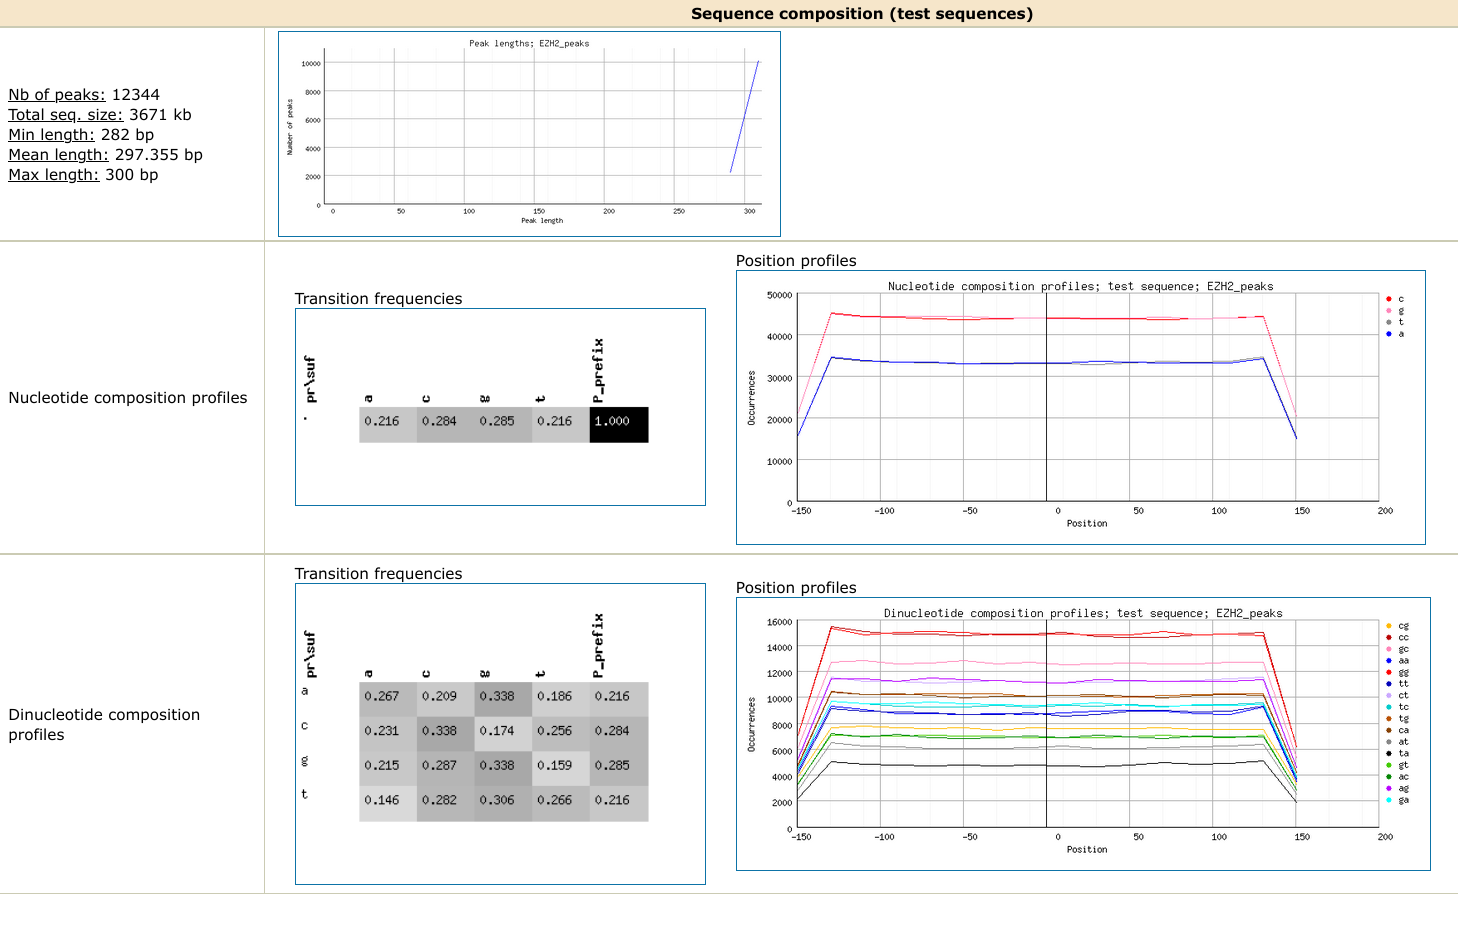

What we can say is that the central region around the peaks is very even in terms of nucleotide composition with a noticeable bias towards C and G sites. The most common dinucleotide pairs are GG and CC with GC close behind. Only CG sites are fairly depleted, likely due to CpG methylation, but they're still more common than GT, TA, and AT, suggesting a high GC content and a presence of (yet) unmethylated CpG islands. The found motifs also show a strong preference for stretches of C and G:

| Motifs part 1 | Motifs part 2 |
| :-: | :-: |
| 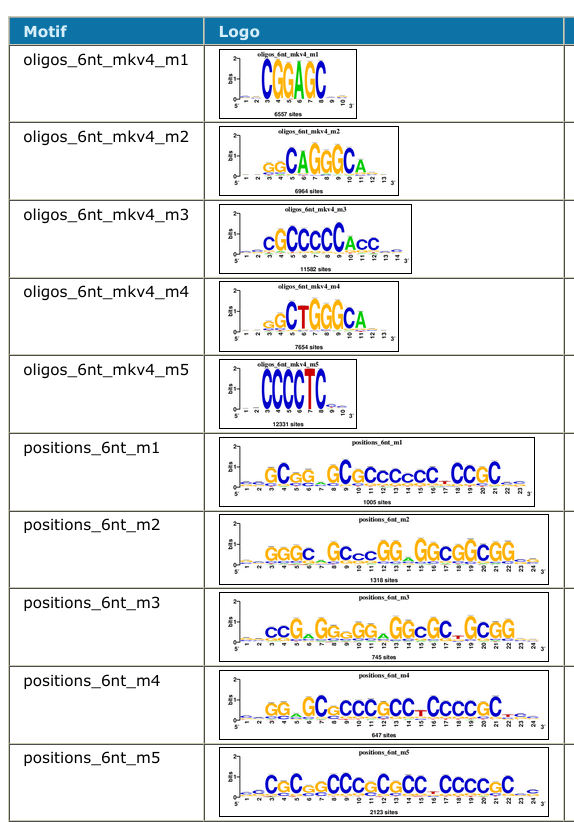 | 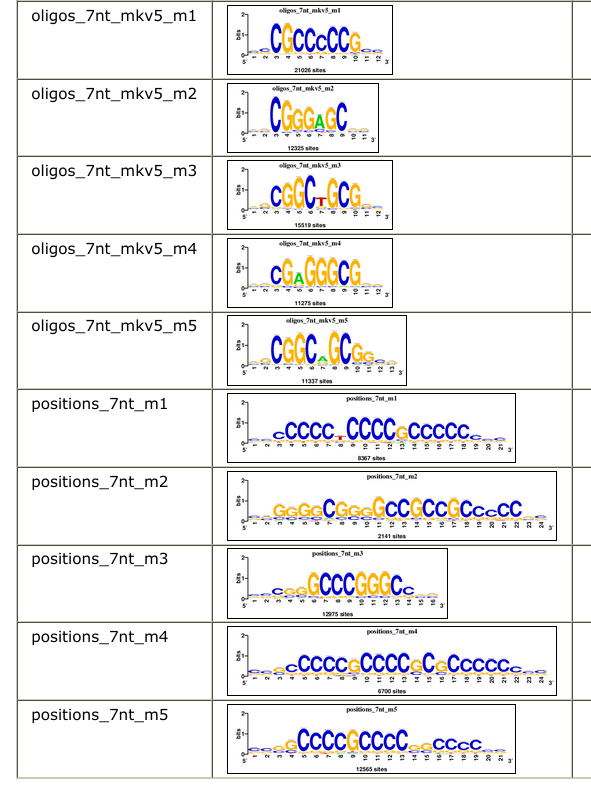 |

Some of the logos show a very strong consensus with almost 2 bits of information for CGGAGC and CCCCTC, for instance. Others show weaker per-base informational content, but are quite broad, like `positions_7nt_m1` running for 24 bases and made up exclusively of Gs and Cs, supporting the documented preference of the complex for CpG islands.

## Gene discovery

RSAT doesn't find any genes for these motifs in the databases we tried, likely because they're calibrated for transcription factors, where PRC2 is a repressive complex that binds to histones. We can still find target genes by using the online tool GREAT.

In order to submit our bed file to GREAT, we'll need to relabel it, since NCBI's human genome uses labels like `NC_` for chromosomes, while `NT_` and `NW_` represent contigs or scaffolds ([HGVS Nomenclature](https://hgvs-nomenclature.org/stable/background/refseq/)). We'll run a script to relabel the chromosomes and remove non-chromosomal reads:

In [18]:
sed 's/^NC_0\+\([0-9]\+\)\.[0-9]\+\t/chr\1\t/' data/peaks/ezh2_old_peaks.bed \
  | sed 's/^chr23/chrX/' \
  | sed 's/^chr24/chrY/' \
  | grep -v '^N' \
  > data/peaks/ezh2_old_peaks.chr.bed

In the search settings, we'll remove the distal extension of 1000kbp completely by setting it to 0. We'd only like to find genes that PRC2 represses directly. The biological processes GREAT suggests for these peaks are mostly related to development and cell differentiation:

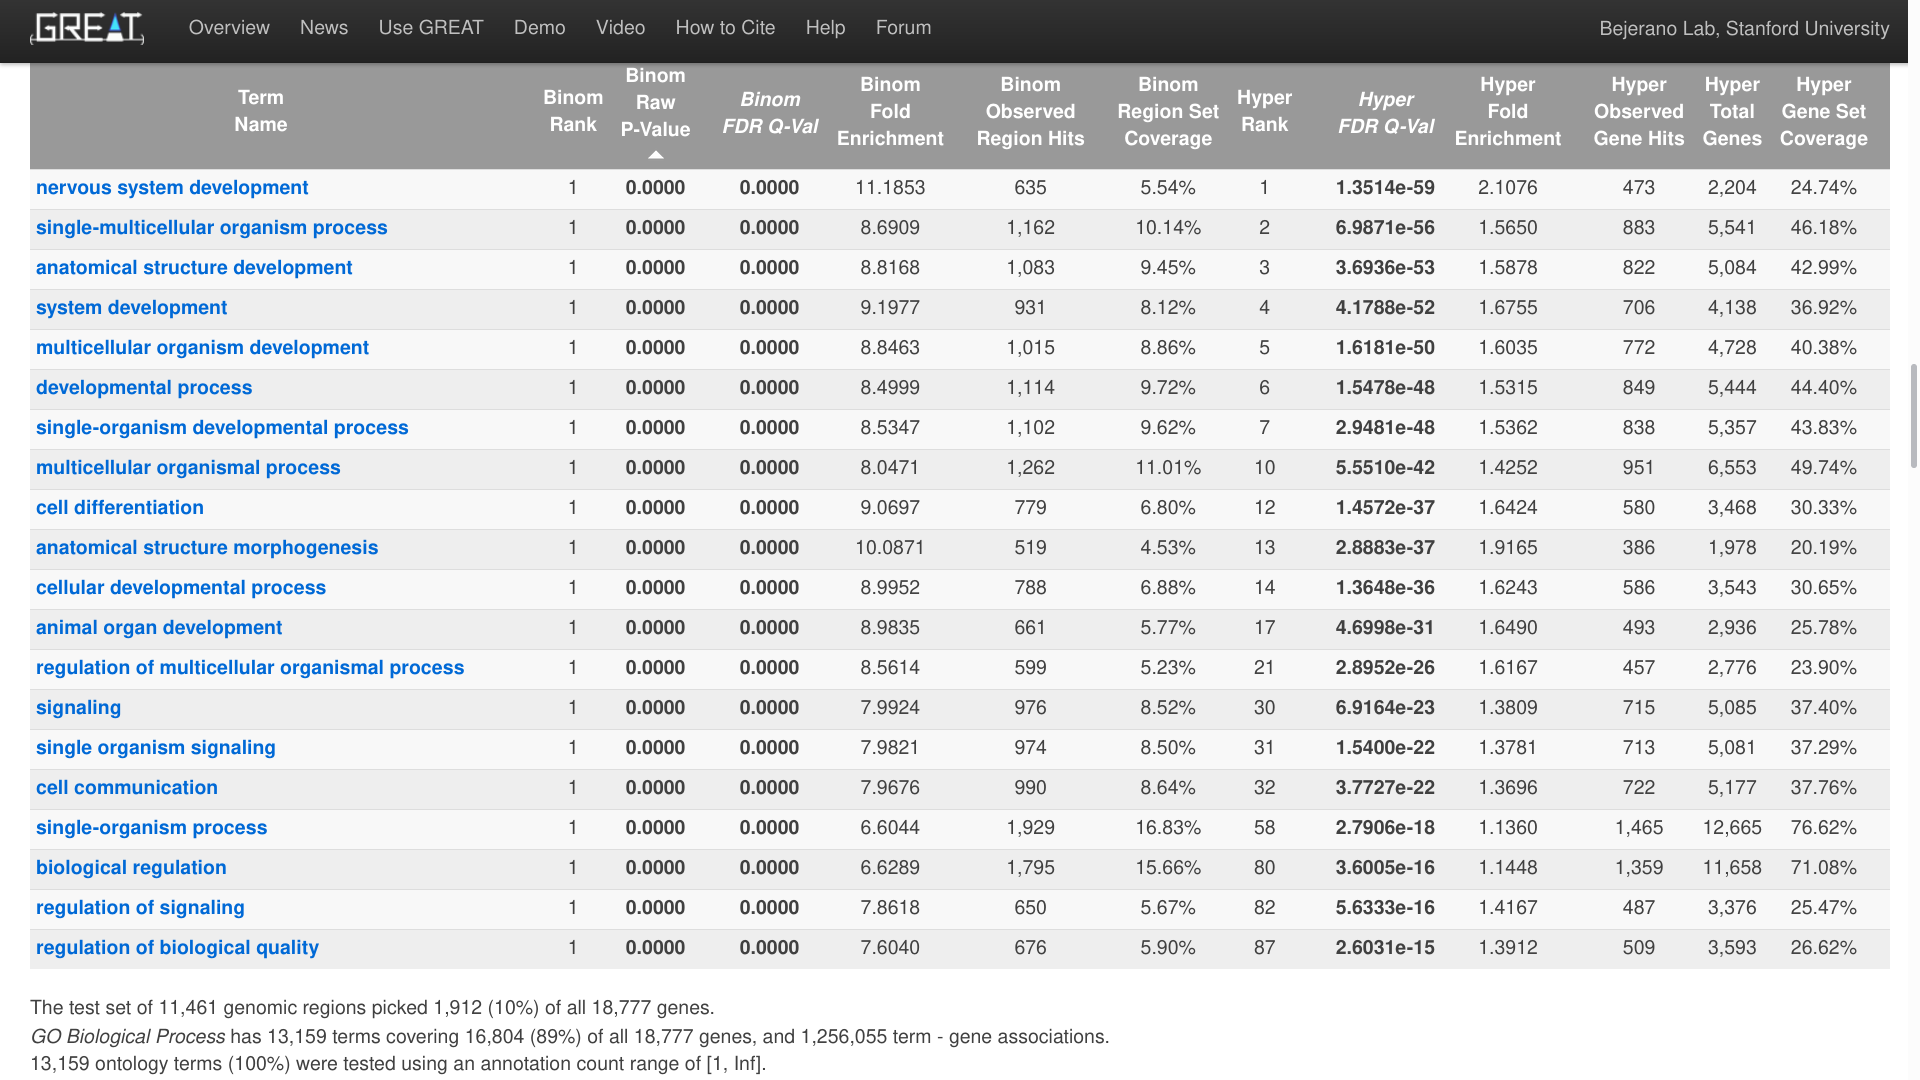

This is only the top 20 processes, but we can already see very strong significance values. We've stored the full TSV of GO:BP results and we can explore it to see that around 30% of the found processes are related to development, differentiation, or morphogenesis:

In [12]:
bp_tsv="/mnt/storage/r0978323/project_data/great/biological_processes.tsv"

echo "> All found biological processes:"
cat "$bp_tsv" | grep -v '^#' | wc -l

echo "> Development-related:"
cat "$bp_tsv" | grep -e '\(development\|differentiation\|morphogenesis\)' | wc -l

> All found biological processes:
500
> Development-related:
147


The Polycomb Repressive Complex 2 is part of the polycomb complexes known from Drosophila to suppress Hox genes, so seeing these terms enriched makes perfect sense. The list of genes that GREAT finds is 1912 entries long:

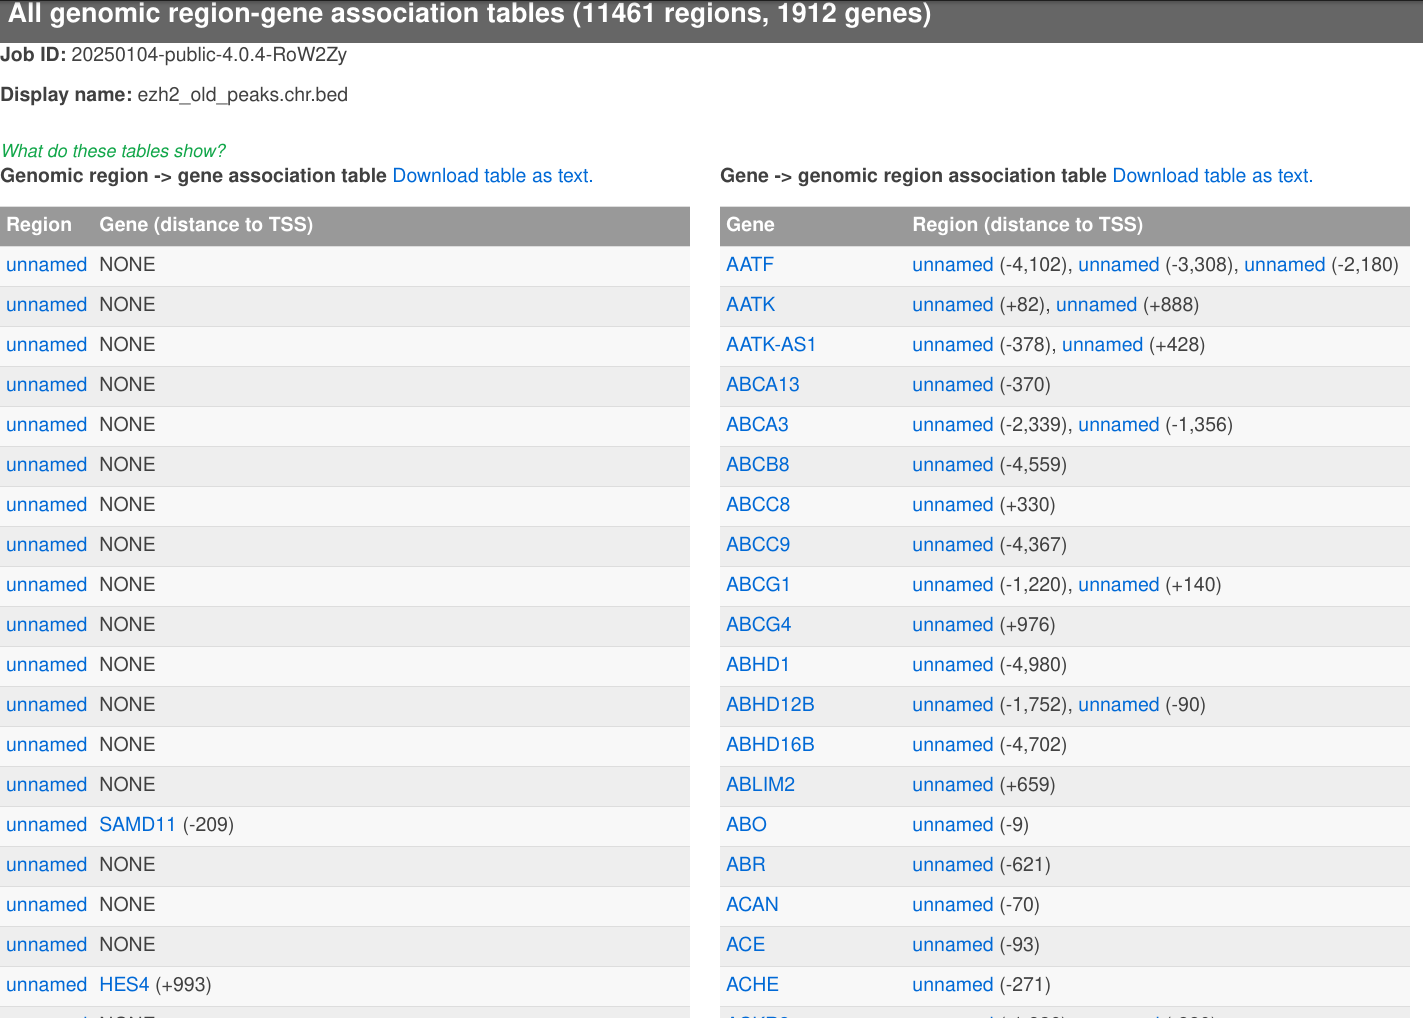

It's easier to look through it programmatically. We've saved a copy of the two lists, gene-to-region and region-to-gene, and we can look for some particular targets important to development and cell differentiation:

In [13]:
region_to_gene="/mnt/storage/r0978323/project_data/great/region_to_gene.txt"
gene_to_region="/mnt/storage/r0978323/project_data/great/gene_to_region.txt"

echo "Total regions:"
wc -l "$region_to_gene"
echo "Total genes:"
wc -l "$gene_to_region"
echo

echo "HOX genes:"
grep "^HOX" "$gene_to_region" | cut -f1 | tr '\n' ',' | sed 's/,/, /g' | sed 's/, $//'
echo
echo
echo "Pair-rule genes:"
grep "^PAX" "$gene_to_region" | cut -f1 | tr '\n' ',' | sed 's/,/, /g' | sed 's/, $//'
echo
echo
echo "Cyclin-dependent kinases:"
grep "^CDK" "$gene_to_region" | cut -f1 | tr '\n' ',' | sed 's/,/, /g' | sed 's/, $//'

Total regions:
11463 /mnt/storage/r0978323/project_data/great/region_to_gene.txt
Total genes:
1914 /mnt/storage/r0978323/project_data/great/gene_to_region.txt

HOX genes:
HOXA13, HOXB13, HOXB9, HOXC12, HOXC13, HOXD1, HOXD10, HOXD11, HOXD12, HOXD13, HOXD3, HOXD8, HOXD9

Pair-rule genes:
PAX2, PAX3, PAX4, PAX5, PAX6, PAX9

Cyclin-dependent kinases:
CDK18, CDK4, CDKN2A

If we were in doubt that PRC2 interacts with organismal development and cell differentiation, these are just a few examples that might dispel that.

It's interesting to check whether the peak file we downloaded from the GEO accession finds the same genes. Recall that it listed more detected peaks, but we assumed those peaks were co-located next to ours. We can upload a bed file from the downloaded narrowPeak file and see how many results we get from that:

In [17]:
cat data/peaks/ezh2_old_downloaded.narrowPeak | cut -f 1-3 > data/peaks/ezh2_old_downloaded.bed

Frustratingly, it seems there's around 900 more genes that are found with these extra peaks:

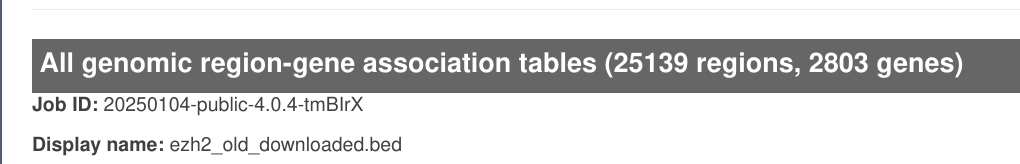

We can download that list and rerun the above greps to investigate the targets:

In [18]:
region_to_gene="/mnt/storage/r0978323/project_data/great/region_to_gene_downloaded.txt"
gene_to_region="/mnt/storage/r0978323/project_data/great/gene_to_region_downloaded.txt"

echo "Total regions:"
wc -l "$region_to_gene"
echo "Total genes:"
wc -l "$gene_to_region"
echo

echo "HOX genes:"
grep "^HOX" "$gene_to_region" | cut -f1 | tr '\n' ',' | sed 's/,/, /g' | sed 's/, $//'
echo
echo
echo "Pair-rule genes:"
grep "^PAX" "$gene_to_region" | cut -f1 | tr '\n' ',' | sed 's/,/, /g' | sed 's/, $//'
echo
echo
echo "Cyclin-dependent kinases:"
grep "^CDK" "$gene_to_region" | cut -f1 | tr '\n' ',' | sed 's/,/, /g' | sed 's/, $//'

Total regions:
25141 /mnt/storage/r0978323/project_data/great/region_to_gene_downloaded.txt
Total genes:
2805 /mnt/storage/r0978323/project_data/great/gene_to_region_downloaded.txt

HOX genes:
HOXA11, HOXA13, HOXB9, HOXC11, HOXC13, HOXD1, HOXD10, HOXD11, HOXD12, HOXD13, HOXD3, HOXD8, HOXD9

Pair-rule genes:
PAX1, PAX2, PAX3, PAX4, PAX6, PAX9

Cyclin-dependent kinases:
CDK18, CDK4, CDKN2A

It's interesting, because the second list is not a complete superset of the first. For example, our peaks are missing HOXA11 and HOXC11, but the downloaded peaks miss HOXC12. Here's an IGV visualization of where peaks are located relative to HOXA11:

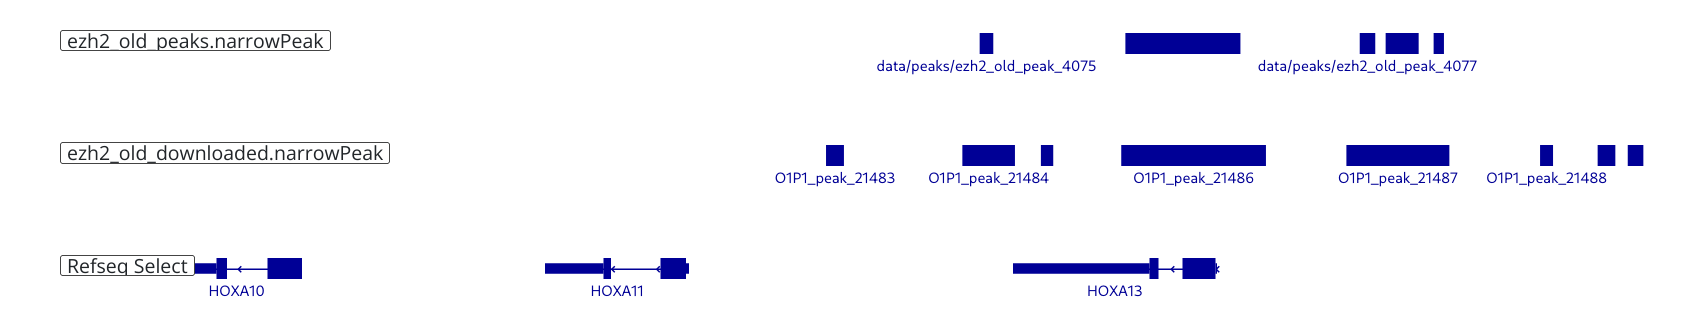

We can see that in this case it's a matter of degree -- our peaks are there, but they're far enough that GREAT does not consider them as interfering with transcription. A stricter sensitivity of peak detection might mean we miss this (possible) interaction.

HOXC12 is an odd case:

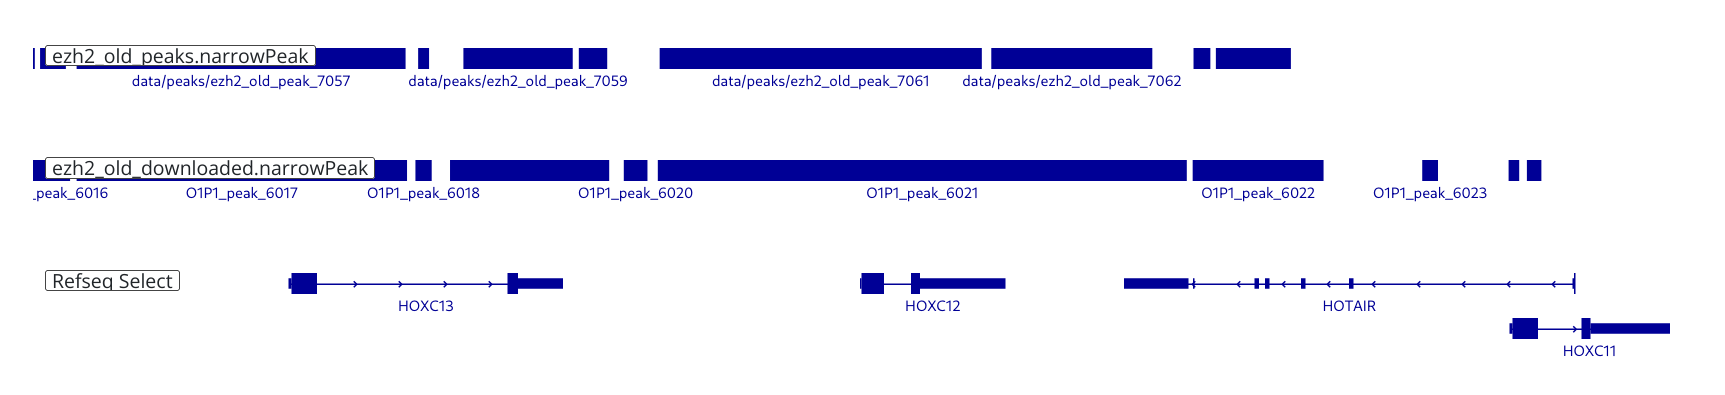

Both our peaks and the downloaded ones seem to cover and repress HOXC12, but GREAT only shows this as a result in our peaks and now the downloaded ones. What might be happening is that GREAT only considers the *center* of the peak, so the broad downloaded one isn't detected, even if it visibly covers the entire area.

## Closing thoughts

Building our own bowtie2 database out of the downloaded NCBI genome might have made our lives more complicated than they needed to be. Sticking to UCSC could have saved us some work and might have made our results more compatible with the ones in the study. Still, it was a useful experience, a peek into the complexity of the work that goes into deriving inferences from genomic data.

The ChIP-seq experiment not being a classic transcription factor gives us a different view on the results than we would get from a TP53 assay, for instance. The bindings we found were mostly punctate around transcription starts, but they would also spread across genes, which seems like a reasonable pattern for a histone-bound repressor. Motif enrichment gave us strong support for PRC2 binding in CpG islands, and gene enrichment showed us very significant associations with developmental genes, supporting our previous knowledge of the complex being part of the polycomb group proteins with vital roles in epigenetic silencing during and after embryonal development.

While this part of the analysis is just a small part of the original study, it was an interesting exploration. There are some remaining questions about the exact concordance of our results with the ones in the paper, but ultimately, our qualitative inferences are consistent with what we can find in the literature.